# Adaptive Questionnaires

In [1]:
import WassersteinTSNE as WT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../src')
import utils.visualization as vis
import utils.preprocession as prep
from utils.metrics import NearestCandidates, overlap
from models.IDEAL import IDEAL
import utils.methods as al

import textwrap



## Config

In [2]:
save_figures = False
folder_name = 'Smartvote'
data_name = 'Binary'
p = 90

## Data

In [3]:
def savefig(fig, name='TestFigure'): 
    if save_figures:
        fig.savefig(f"../../reports/ecpr-conference/figures/{folder_name}_{data_name}_{name}.pdf") 

folder_path = f"../../data/{folder_name}"
data_path = f"../../data/{folder_name}/{data_name}"

test_users = pd.read_csv(f'{folder_path}/test_candidates.csv', index_col=0)
train_users = pd.read_csv(f'{folder_path}/train_candidates.csv', index_col=0)

train_reactions = pd.read_csv(f'{data_path}/train_reactions_0.csv', index_col=0)
start_reactions = pd.read_csv(f'{data_path}/test_reactions_{p}.csv', index_col=0)
test_reactions = pd.read_csv(f'{data_path}/test_reactions_0.csv', index_col=0)

statements = pd.read_csv(f"../../data/{folder_name}/statements.csv", index_col=0)

K = test_reactions.shape[1]
start_reactions.head()


0   1    2   3   4    5   6    7   8   9  ...  65  66   67  68   69  70  \
5   NaN NaN  NaN NaN NaN  0.0 NaN  NaN NaN NaN  ... NaN NaN  NaN NaN  0.0 NaN   
9   1.0 NaN  1.0 NaN NaN  NaN NaN  NaN NaN NaN  ... NaN NaN  NaN NaN  NaN NaN   
12  NaN NaN  NaN NaN NaN  NaN NaN  NaN NaN NaN  ... NaN NaN  1.0 NaN  NaN NaN   
16  NaN NaN  NaN NaN NaN  NaN NaN  0.0 NaN NaN  ... NaN NaN  NaN NaN  NaN NaN   
26  NaN NaN  NaN NaN NaN  NaN NaN  NaN NaN NaN  ... NaN NaN  NaN NaN  NaN NaN   

     71  72  73   74  
5   NaN NaN NaN  0.0  
9   0.0 NaN NaN  NaN  
12  NaN NaN NaN  NaN  
16  NaN NaN NaN  0.0  
26  1.0 NaN NaN  NaN  

[5 rows x 75 columns]

## Model

In [4]:
method_path = f"../../embeddings/IDEAL/{folder_name}"
start_embedding = pd.read_csv(f'{method_path}/test_embedding_0_{p}.csv', index_col=0)
test_embedding = pd.read_csv(f'{method_path}/test_embedding_0_0.csv', index_col=0)
train_embedding = pd.read_csv(f'{method_path}/train_embedding_0.csv', index_col=0)

ideal = IDEAL(pd.read_csv(f'{method_path}/betabar_0.csv', index_col=0), 
              pd.read_csv(f'{method_path}/xbar_0.csv', index_col=0),
              index=train_reactions.index, columns=train_reactions.columns)

d, r = 2, 200
ideal.make_probabilistic(d=d, r=r)

## Questions

In [5]:
variances = ideal.items.apply(lambda row: np.linalg.norm(row[['Discrimination D1', 'Discrimination D2']]), axis=1)
q1, q2 = variances.argmin(), variances.argmax()
q1, q2

(15, 5)

In [6]:
prior_probs = (ideal.likelihood_X.values * ideal.prior_X.reshape(-1,1)).sum(axis=0)
prior_gini  = 2 * prior_probs * (1-prior_probs)
q3, q4 = prior_gini.argmin(), prior_gini.argmax()
q3, q4

(19, 7)

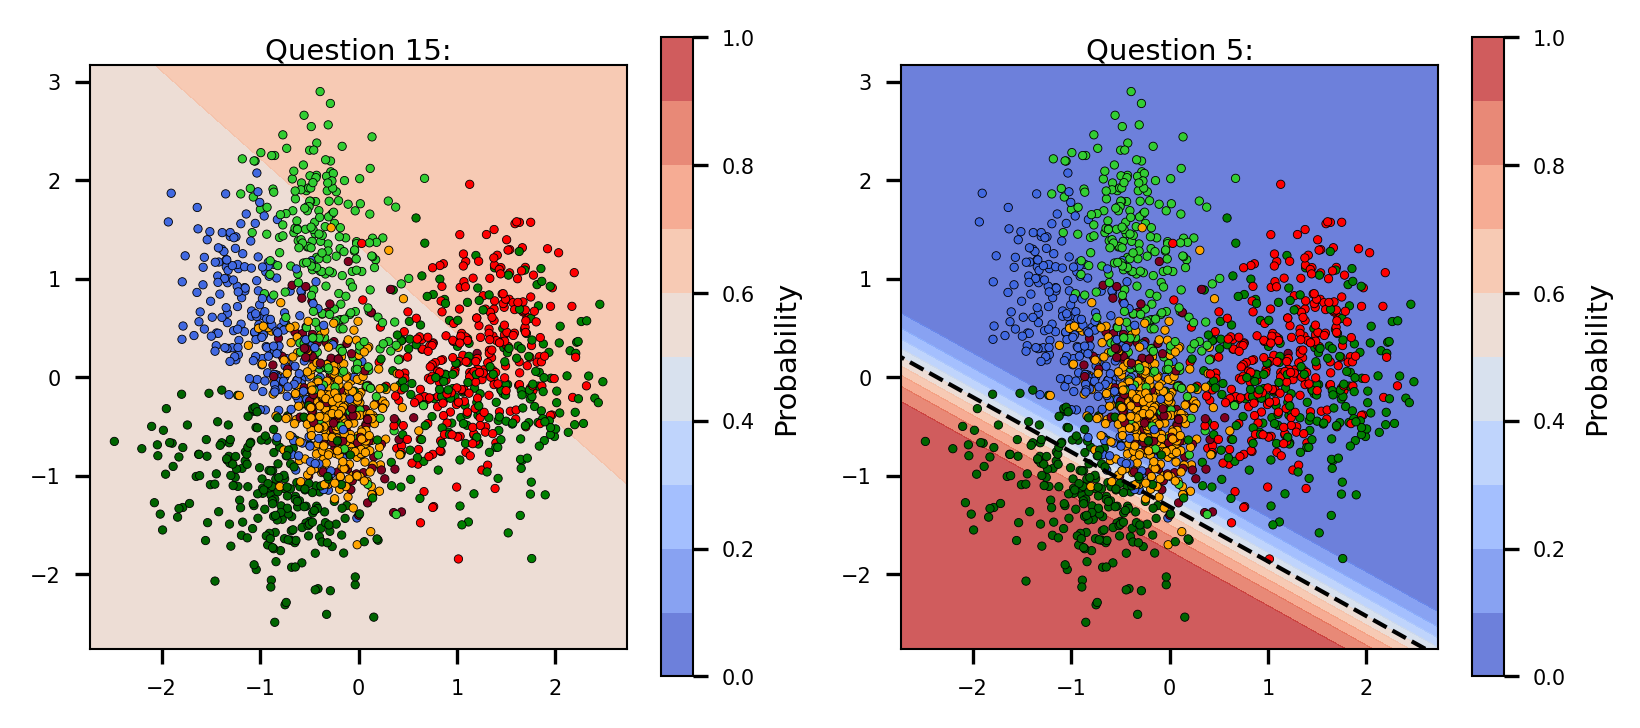

In [10]:
def plotQuestion(q, ax=None, mark=None):
    #_, ax, _ = vis.figure(ax)
    title = statements.loc[q, 'question']

    # Wrap this text.
    wrapper = textwrap.TextWrapper(width=50) # Adjust width to your preference
    word_list = wrapper.wrap(text=title)
    word_list=[]
    # Convert the word list to a single string with line breaks
    title_with_breaks = '\n'.join([f'Question {q}:']+word_list)

    ax = vis.plotEmbedding(train_embedding, ax=ax, s=4, c=train_users['color'])            
    ax.set_title(title_with_breaks)
    vis.plotFeature(ideal.predict, q, ax=ax)
    if mark is not None:
        ax.scatter(mark[0], mark[1], marker='x', color='black', s=5, lw=1, label='Optimized Coordinates', zorder=5)

    #vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=4)

def compareQuestions(q1, q2, mark=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.beamerwidth,vis.beamerheight))
    plotQuestion(q1, ax=ax1, mark=mark)
    plotQuestion(q2, ax=ax2, mark=mark)
    fig.tight_layout()
    savefig(fig, f'CompareQuestions_{q1}_{q2}')
    return fig

fig = compareQuestions(q1, q2)


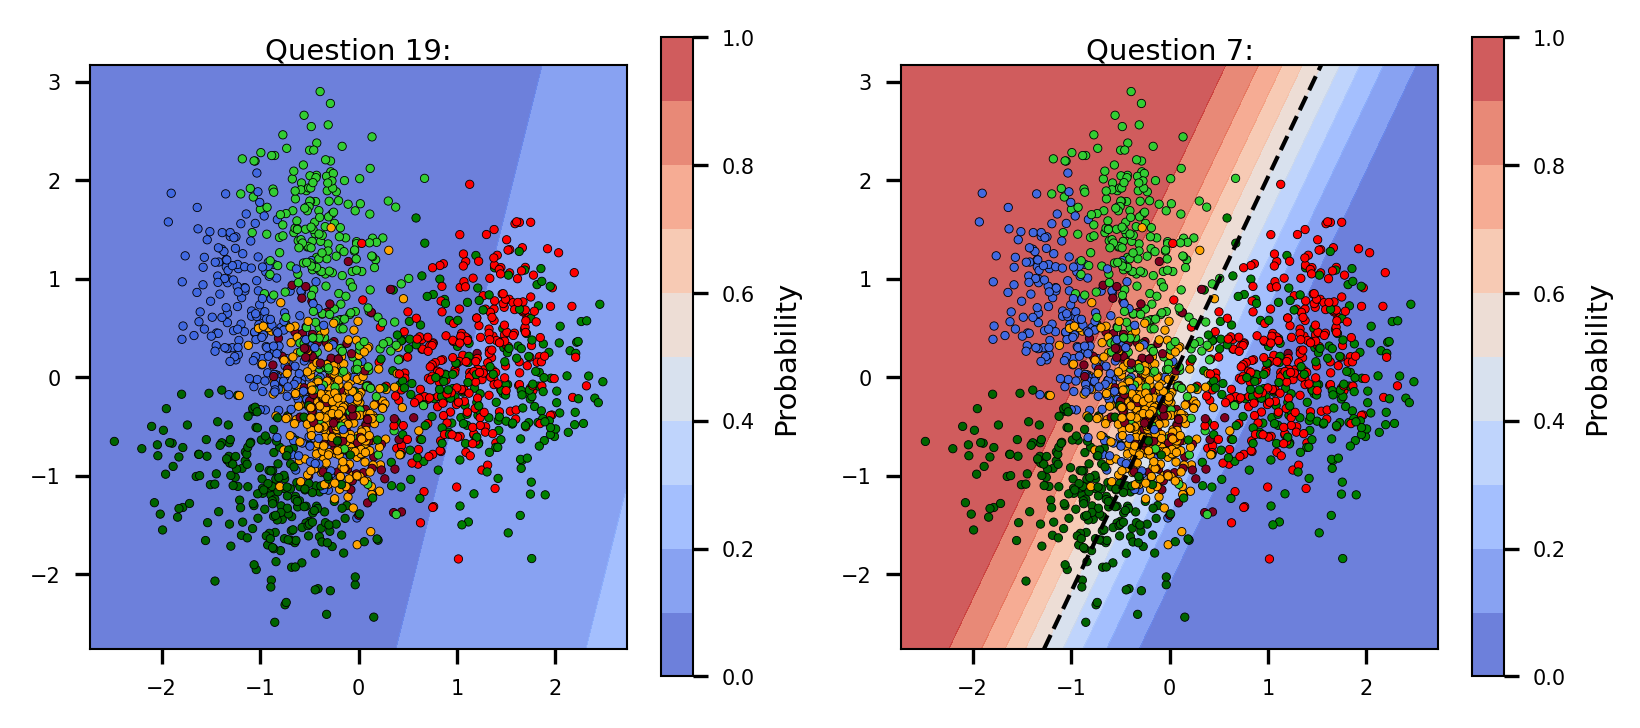

In [11]:
fig = compareQuestions(q3, q4)

## Prior

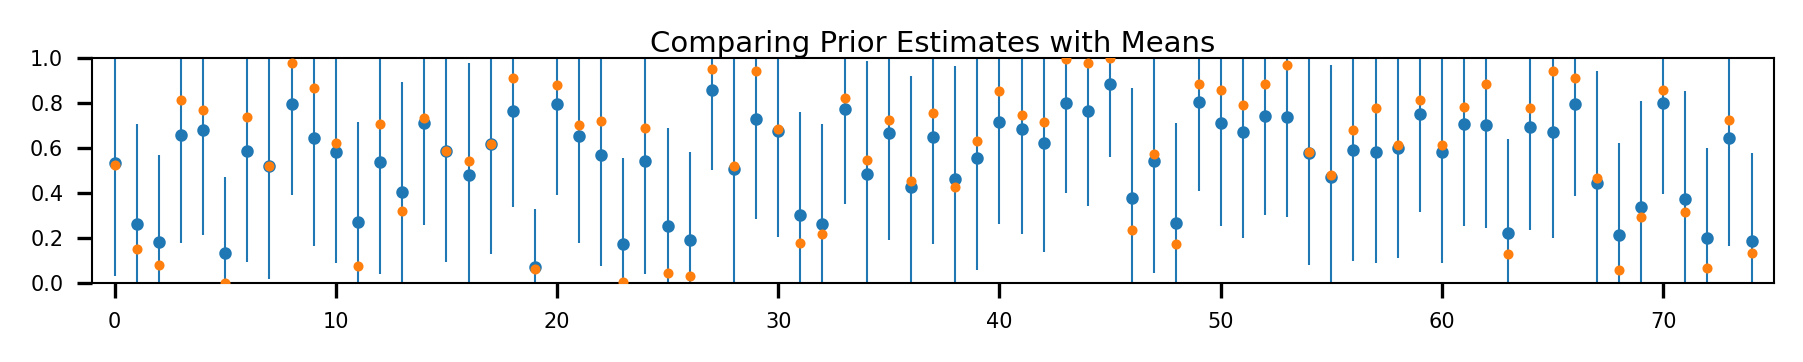

In [12]:
prior_mean = np.array([0,0])
prediction = ideal.predict(prior_mean)

fig, ax= plt.subplots(figsize=(vis.beamerwidth_,0.5*vis.beamerheight))
ax.errorbar(range(K), train_reactions.mean(), yerr=train_reactions.std(), fmt="o", color='C0',ms=2,lw=0.5)
ax.scatter(range(K), prediction, color='C1', s=2, zorder=5)
ax.set(ylim=(0,1),
       xlim=(-1,K),
       title='Comparing Prior Estimates with Means')
fig.tight_layout()
savefig(fig, f'PriorEstimates')


In [17]:
def showUser(n,q, method=ideal.objective):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(vis.beamerwidth,vis.beamerheight))
    for ax in (ax1,ax2):
        ax.set(xlim=(-3,3),
                ylim=(-3,3))
    ax1 = vis.plotEmbedding(start_embedding, n=n, ax=ax1, s=4, c=test_users['color'],
                            highlight={'s':5, 'lw':.5})            
    ax1.set_title(f'Posterior after 5 questions\n for Test User {n}')
    #vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=2)

    user = start_reactions.loc[n]
    answers = user.loc[~user.isna()]
    vis.plotObjective(method, answers, d=0, r=r, ax=ax1)
    vis.plotObjective(lambda X, answers: ideal.prior.pdf(X), answers, ax=ax2)
    ax2 = vis.plotEmbedding(train_embedding, ax=ax2, s=4, c=train_users['color'])  
    ax2.set_title(f'Train Users over Gaussian Prior')

    fig.tight_layout()
    return fig, ax1

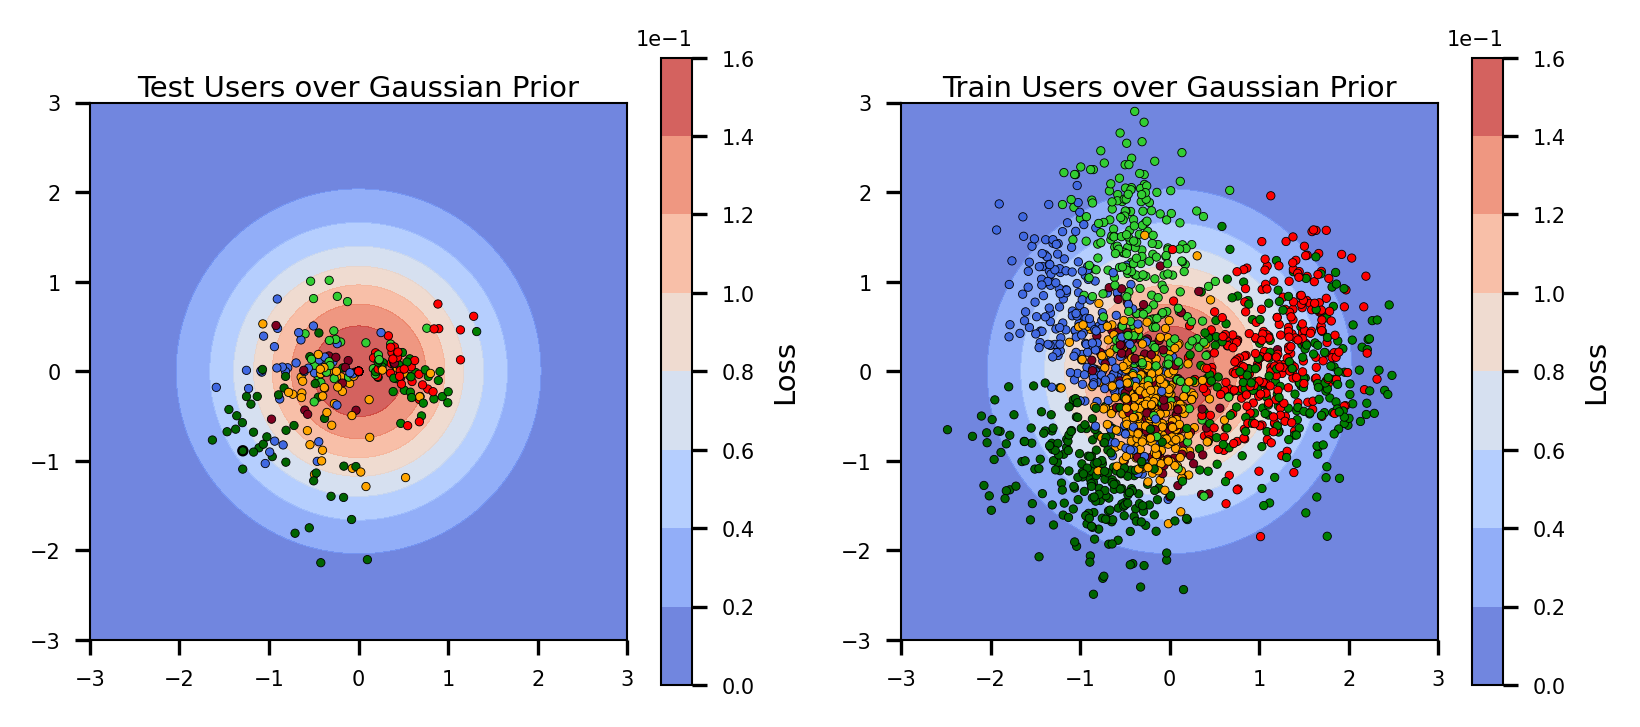

In [18]:
n, q = 459, 24
user = start_reactions.loc[n]
answers = user.loc[~user.isna()]
fig, ax = showUser(n,q, lambda X, answers: ideal.prior.pdf(X))
ax.set_title('Test Users over Gaussian Prior')
savefig(fig, 'PriorVisualization')

## Posterior

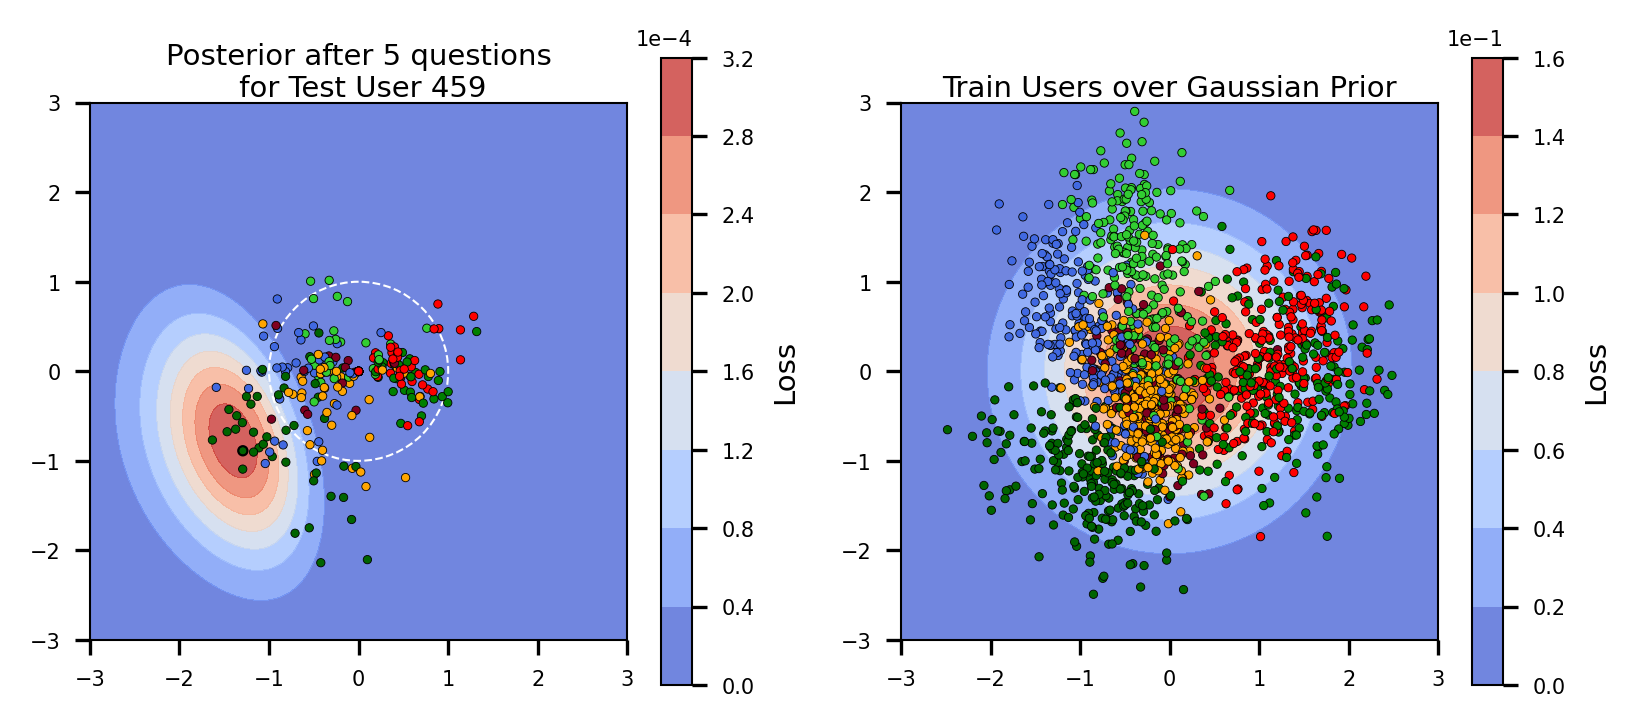

In [19]:
fig, ax = showUser(n, 0, ideal.posterior)
G = WT.GaussianDistribution(np.array([0,0]), WT.arr2cov(np.eye(2)))
# G = WT.GaussianDistribution().estimate(ideal.train_embedding.values)
ax = vis.plotGaussian(G, ax=ax, edgecolor='white', linewidth=0.5, zorder=1)
savefig(fig, 'PosteriorVisualization')

## Question Selection

In [20]:
n = 459
user = start_reactions.loc[n]
# user = test_reactions.loc[n]
# user.loc[[str(i) for i in range(12, 35)]] = np.NaN

### SET user=... for debuggging
given_answers = user.loc[~user.isna()]
open_answers = user.loc[user.isna()]

P_Yn1_X = ideal.likelihood_X.loc[:,open_answers.index].values ## (40000, 45)
P_Yn0_X = 1 - P_Yn1_X
P_X_Yi = ideal.posterior_X(given_answers) ## (40000,1)

P_XYn0_Yi = P_Yn0_X * P_X_Yi ## (40000, 45)
P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
assert np.all(np.isclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5)), "X Posteriors don't sum to 1"

P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
# P_X_Yin1  = P_XYn1_Yi / P_Yn1_Yi ## (40000, 45)
# P_X_Yin0  = P_XYn0_Yi / P_Yn0_Yi ## (40000, 45)
assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

P_Yn1_Yin1 = np.tensordot(P_Yn1_X, P_X_Yin1, axes=[0,0]) ## (45,45)
P_Yn1_Yin0 = np.tensordot(P_Yn1_X, P_X_Yin0, axes=[0,0]) ## (45,45)
P_Yn0_Yin1 = np.tensordot(P_Yn0_X, P_X_Yin1, axes=[0,0]) ## (45,45)
P_Yn0_Yin0 = np.tensordot(P_Yn0_X, P_X_Yin0, axes=[0,0]) ## (45,45)
assert np.allclose(P_Yn1_Yin1 + P_Yn0_Yin1, 1, rtol=1e-5)
assert np.allclose(P_Yn1_Yin0 + P_Yn0_Yin0, 1, rtol=1e-5)

### Posterior RMSE

In [21]:
### PRIOR GINI (FOR ALL REMAINING QUESTIONS)
prior_gini = 2 * (P_Yn1_Yi * P_Yn0_Yi)

### POSTERIOR GINI (If Yn=0) 
gini_Yn0 = 2 * P_Yn0_Yin0 * P_Yn1_Yin0
np.fill_diagonal(gini_Yn0, 0)
gini_Yn0 = gini_Yn0.sum(axis=0)

### POSTERIOR GINI (If Yn=1) 
gini_Yn1 = 2 * P_Yn0_Yin1 * P_Yn1_Yin1
np.fill_diagonal(gini_Yn1, 0)
gini_Yn1 = gini_Yn1.sum(axis=0)

posterior_gini_sum = P_Yn1_Yi*gini_Yn1 + P_Yn0_Yi*gini_Yn0
posterior_rmse_loss = prior_gini.sum() - posterior_gini_sum

### Posterior Variance

In [22]:
def gauss_fit(X,W):
    mu = (X*W).sum(axis=0)
    tmp = (X-mu)*np.sqrt(W)
    cov = WT.arr2cov((tmp.T @ tmp) / (1- (W**2).sum()))
    return WT.GaussianDistribution(mu, cov)

### This NEEDS to be vectorized
gauss_posteriors = []
for k in range(len(open_answers)):
    tmp = []
    for df in [P_X_Yin0, P_X_Yin1]:
        tmp.append(gauss_fit(ideal.X, df[:,k].reshape(-1,1)))
    gauss_posteriors.append(tmp)

In [23]:
### FIRST compute PRIOR variance
mean = (P_X_Yi * ideal.X).sum(axis=0)
distance_to_mean = ((ideal.X - mean)**2).sum(axis=1).reshape(-1,1)
prior_var = (distance_to_mean * P_X_Yi).sum()

### Alternative computation for prior
mean = (ideal.X[:, :, np.newaxis] * P_X_Yi[:, np.newaxis, :]).sum(axis=0) ## (40000,2)
distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1) ## (40000,1)
prior_var_test = (distance_to_mean * P_X_Yi).sum(axis=0) ## (1,)
assert np.isclose(prior_var, prior_var_test)

### Now for the POSTERIOR variance (given Yn=1)
mean = (ideal.X[:, :, np.newaxis] * P_X_Yin1[:, np.newaxis, :]).sum(axis=0) ## (40000,2)
distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1) ## (40000,45)
var_Yn1 = (distance_to_mean * P_X_Yin1).sum(axis=0) ## (45,)

### Now for the POSTERIOR variance (given Yn=0)
mean = (ideal.X[:, :, np.newaxis] * P_X_Yin0[:, np.newaxis, :]).sum(axis=0)
distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1)
var_Yn0 = (distance_to_mean * P_X_Yin0).sum(axis=0)

posterior_var = P_Yn1_Yi*var_Yn1 + P_Yn0_Yi*var_Yn0
posterior_var_loss = prior_var - posterior_var

### kNN Agreement

In [24]:
%%time 
k = 32
candidates = NearestCandidates(train_reactions, k=k)
base_neighbors = candidates.recommend(user)
base_agreement = train_reactions.loc[base_neighbors, open_answers.index].std(axis=0).values
user_pred = ideal.predict_user(user)
pred_neighbors = candidates.recommend(user_pred)
pred_agreement = train_reactions.loc[pred_neighbors, open_answers.index].std(axis=0).values

CPU times: user 20.9 ms, sys: 17.2 ms, total: 38.1 ms
Wall time: 57.6 ms


### PosteriorKNN 

In [25]:
### FIRST compute PRIOR KNN Variance
factor = 20
n_samples = user.isna().sum()*factor
predictions = ideal.predict_user(user)
indices = candidates.recommend(predictions)
prior = candidates.probabilistic(pd.DataFrame(predictions).T, n_samples=n_samples)
print(np.allclose(indices, train_reactions.iloc[prior.iloc[0,0]].index), prior.iloc[0,1], n_samples)

### Now for the POSTERIOR KNN variance (given Yn=1)
pseudo_answers_Y1 = pd.DataFrame([user]*len(open_answers.index))
pseudo_answers_Y1.index = open_answers.index
pseudo_answers_Y1.loc[:,open_answers.index] = P_Yn1_Yin1.T
result_Y1 = candidates.probabilistic(pseudo_answers_Y1, n_samples=n_samples)

### Now for the POSTERIOR KNN variance (given Yn=0)
pseudo_answers_Y0 = pd.DataFrame([user]*len(open_answers.index))
pseudo_answers_Y0.index = open_answers.index
pseudo_answers_Y0.loc[:,open_answers.index] = P_Yn1_Yin0.T
result_Y0 = candidates.probabilistic(pseudo_answers_Y0, n_samples=n_samples)

### Now compute the expected loss of POSTERIOR KNN 
posterior_knn = P_Yn1_Yi*result_Y1.loc[open_answers.index, 'variance'] + (1-P_Yn1_Yi)*result_Y0.loc[open_answers.index, 'variance']
posterior_knn_loss = 100*(prior.iloc[0,1] - posterior_knn).values

True 0.6386259191176471 1360


In [26]:
open_questions = pd.concat([pd.Series(P_Yn0_Yi, name='prob no'),
                            pd.Series(P_Yn1_Yi, name='prob yes'),
                            pd.Series(prior_gini, name='prior gini'),
                            pd.Series(base_agreement, name='base agreement'),
                            pd.Series(pred_agreement, name='pred agreement'),
                            pd.Series(posterior_knn_loss, name='post knn diff'),
                            # pd.Series([z[0].cov.s.sum() for z in gauss_posteriors], name='no post var test'),
                            # pd.Series(var_Yn0, name='post var no'),
                            # pd.Series([z[1].cov.s.sum() for z in gauss_posteriors], name='yes post var test'),
                            # pd.Series(var_Yn1, name='post var yes'),
                            pd.Series(posterior_var_loss, name='post var diff'),
                            # pd.Series(gini_Yn0, name='post gini no'),                            
                            # pd.Series(gini_Yn1, name='post gini yes'),
                            pd.Series(posterior_rmse_loss, name='post rmse diff')
                            ], axis=1).reset_index(drop=False).set_index(open_answers.index)

In [27]:
q1, q2 = open_questions['post var diff'].idxmax(), open_questions['post var diff'].idxmin()
q3, q4 = open_questions['post rmse diff'].idxmax(), open_questions['post rmse diff'].idxmin()
open_questions.sort_values('post var diff', ascending=False).round(2)

index  prob no  prob yes  prior gini  base agreement  pred agreement  \
5       5     0.36      0.64        0.46            0.37            0.30   
23     21     0.23      0.77        0.35            0.30            0.00   
37     34     0.67      0.33        0.45            0.51            0.37   
40     37     0.65      0.35        0.46            0.51            0.34   
2       2     0.39      0.61        0.47            0.50            0.37   
..    ...      ...       ...         ...             ...             ...   
67     62     0.99      0.01        0.02            0.00            0.00   
58     53     0.01      0.99        0.01            0.00            0.00   
59     54     0.01      0.99        0.03            0.25            0.00   
63     58     1.00      0.00        0.01            0.00            0.00   
19     17     0.96      0.04        0.07            0.00            0.00   

    post knn diff  post var diff  post rmse diff  
5            1.32           0.33            1.29  
23           1.87           0.25            1.14  
37          -0.42           0.24            0.89  
40          -0.35           0.22            0.87  
2            1.04           0.15            0.89  
..            ...            ...             ...  
67           0.29           0.01            0.07  
58           0.20           0.00            0.05  
59          -0.28           0.00            0.05  
63           0.10           0.00            0.03  
19          -0.31           0.00            0.07  

[68 rows x 9 columns]

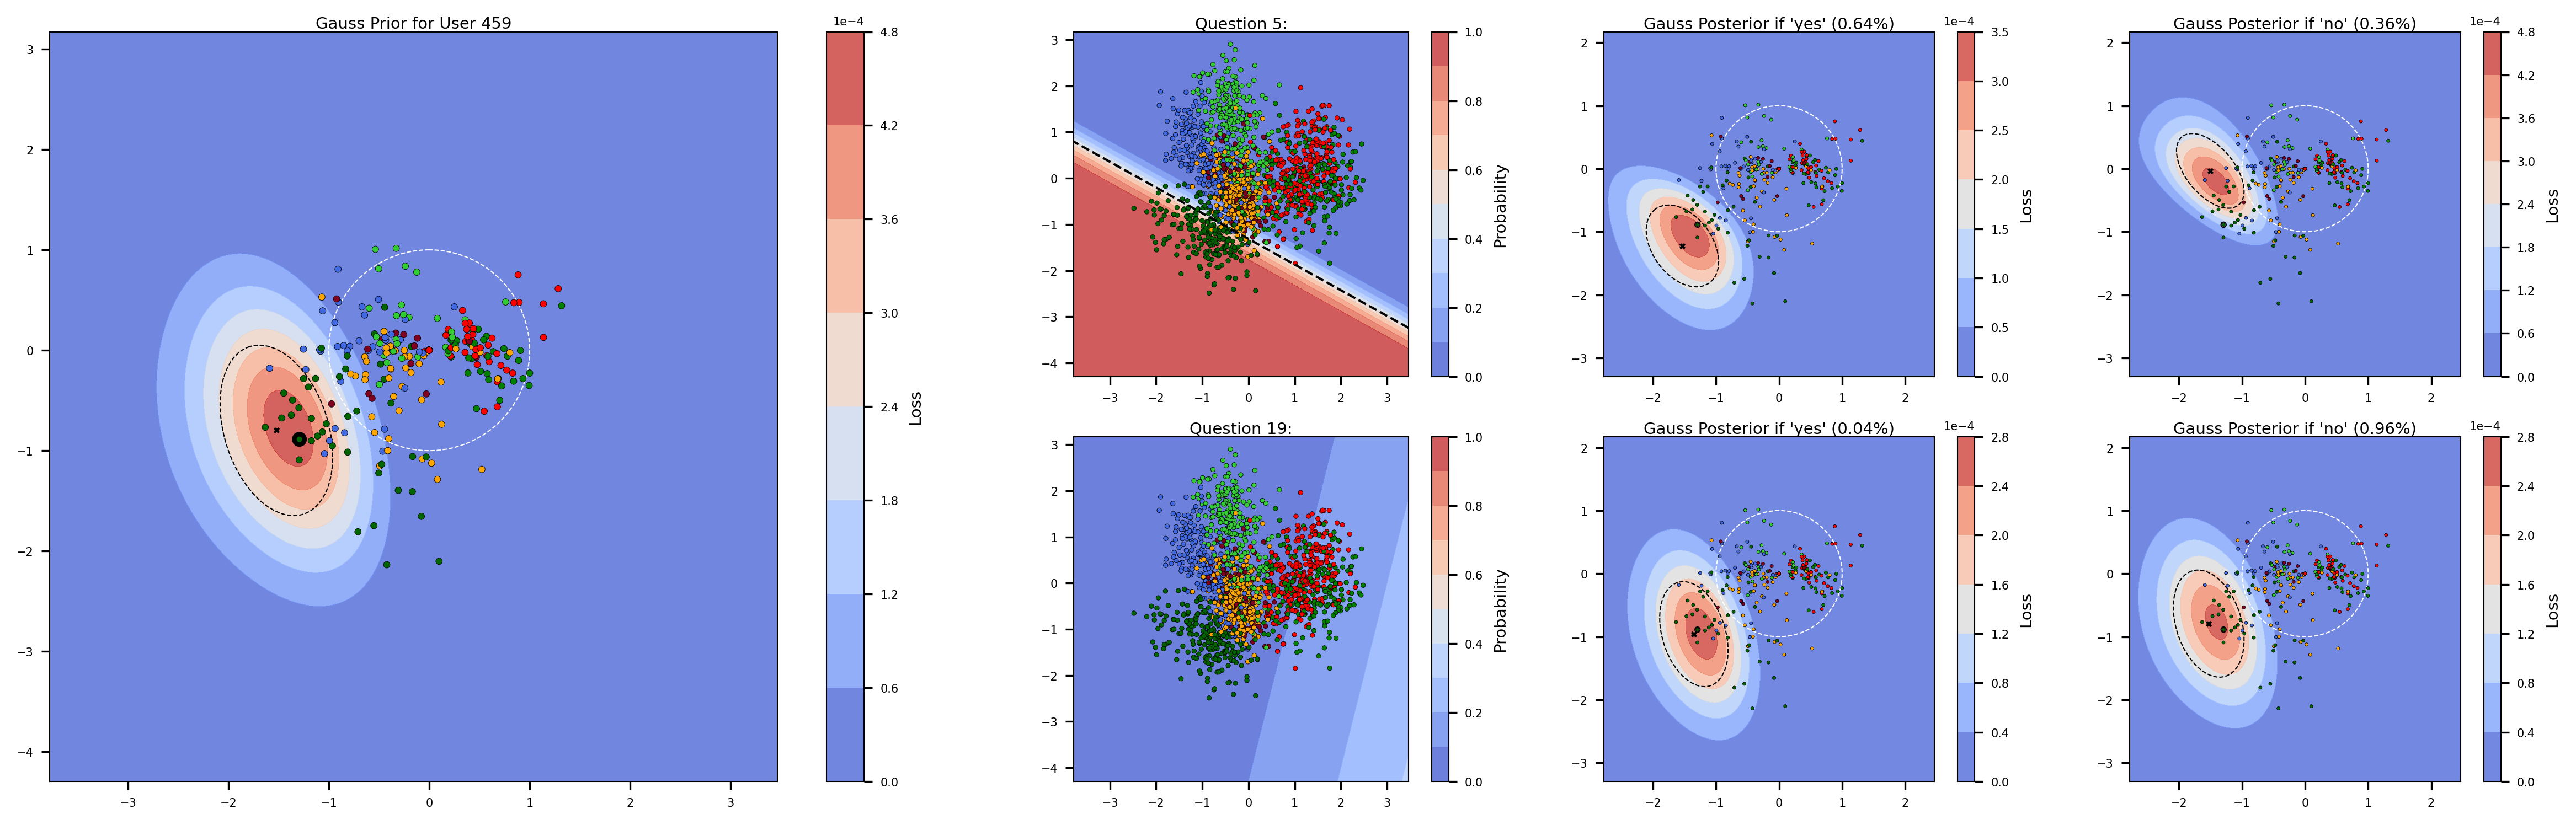

In [30]:
def demoFigure(questions):
    # Create the figure
    fig = plt.figure(figsize=(16, 5))
    n = user.name
    # Add the large subplot at the top, spanning the first two columns
    large_ax = fig.add_subplot(2, 5, (1,7))
    large_ax.set(aspect='equal')
    large_ax = vis.plotEmbedding(start_embedding, n=n, ax=large_ax, s=8, c=test_users['color'],
                                 highlight={'s':20, 'lw':2})            

    vis.plotObjective(ideal.posterior, given_answers, r=r, ax=large_ax, d=d)
    G = WT.GaussianDistribution(np.array([0,0]), WT.arr2cov(np.eye(2)))
    vis.plotGaussian(G, ax=large_ax, edgecolor='white', linewidth=0.5, zorder=1, label='Prior')

    normal = gauss_fit(ideal.X, ideal.posterior_X(given_answers).reshape(-1,1))
    vis.plotGaussian(normal, ax=large_ax, edgecolor='black', linewidth=0.5, zorder=1)
    large_ax.scatter(normal.mean[0], normal.mean[1], marker='x', color='black', s=4)

    large_ax.set_title(f'Gauss Prior for User {n}')

    for row, q in enumerate(questions):
        ax = fig.add_subplot(2, 5, 3+row*5)
        ax.set_title(f'Feature {q}')
        ax.set(xlim=large_ax.get_xlim(),
            ylim=large_ax.get_ylim(),
            aspect='equal'
            )
        plotQuestion(int(q), ax)

        normals = gauss_posteriors[open_answers.index.get_loc(str(q))]

        new_data = pd.Series([1.0], index=[str(q)])
        yes_answer = pd.concat([given_answers, new_data])
        ax1 = fig.add_subplot(2, 5, 4+row*5)
        ax1 = vis.plotEmbedding(start_embedding, n=n, ax=ax1, s=2, c=test_users['color'],
                                highlight={'s':5, 'lw':.5})            
        vis.plotObjective(ideal.posterior, yes_answer, r=200, ax=ax1, d=1)
        vis.plotGaussian(G, ax=ax1, edgecolor='white', linewidth=0.5, zorder=1, label='Prior')
        # normal = gauss_samples(yes_answer)
        vis.plotGaussian(normals[1], ax=ax1, edgecolor='black', linewidth=0.5, zorder=1)
        ax1.scatter(normals[1].mean[0], normals[1].mean[1], marker='x', color='black', s=4)

        ax1.set_title(f"Gauss Posterior if 'yes' ({open_questions.loc[str(q), 'prob yes'].round(2)}%)")

        new_data = pd.Series([0.0], index=[str(q)])
        no_answer = pd.concat([given_answers, new_data])
        ax2 = fig.add_subplot(2, 5, 5+row*5)
        ax2 = vis.plotEmbedding(start_embedding, n=n, ax=ax2, s=2, c=test_users['color'],
                                highlight={'s':5, 'lw':.5})            
        vis.plotObjective(ideal.posterior, no_answer, r=200, ax=ax2, d=1)
        vis.plotGaussian(G, ax=ax2, edgecolor='white', linewidth=0.5, zorder=1, label='Prior')
        # normal = gauss_samples(no_answer)
        vis.plotGaussian(normals[0], ax=ax2, edgecolor='black', linewidth=0.5, zorder=1)
        ax2.scatter(normals[0].mean[0], normals[0].mean[1], marker='x', color='black', s=4)

        ax2.set_title(f"Gauss Posterior if 'no' ({open_questions.loc[str(q), 'prob no'].round(2)}%)")

    fig.tight_layout()
    return fig

_ = demoFigure([q1,q2])


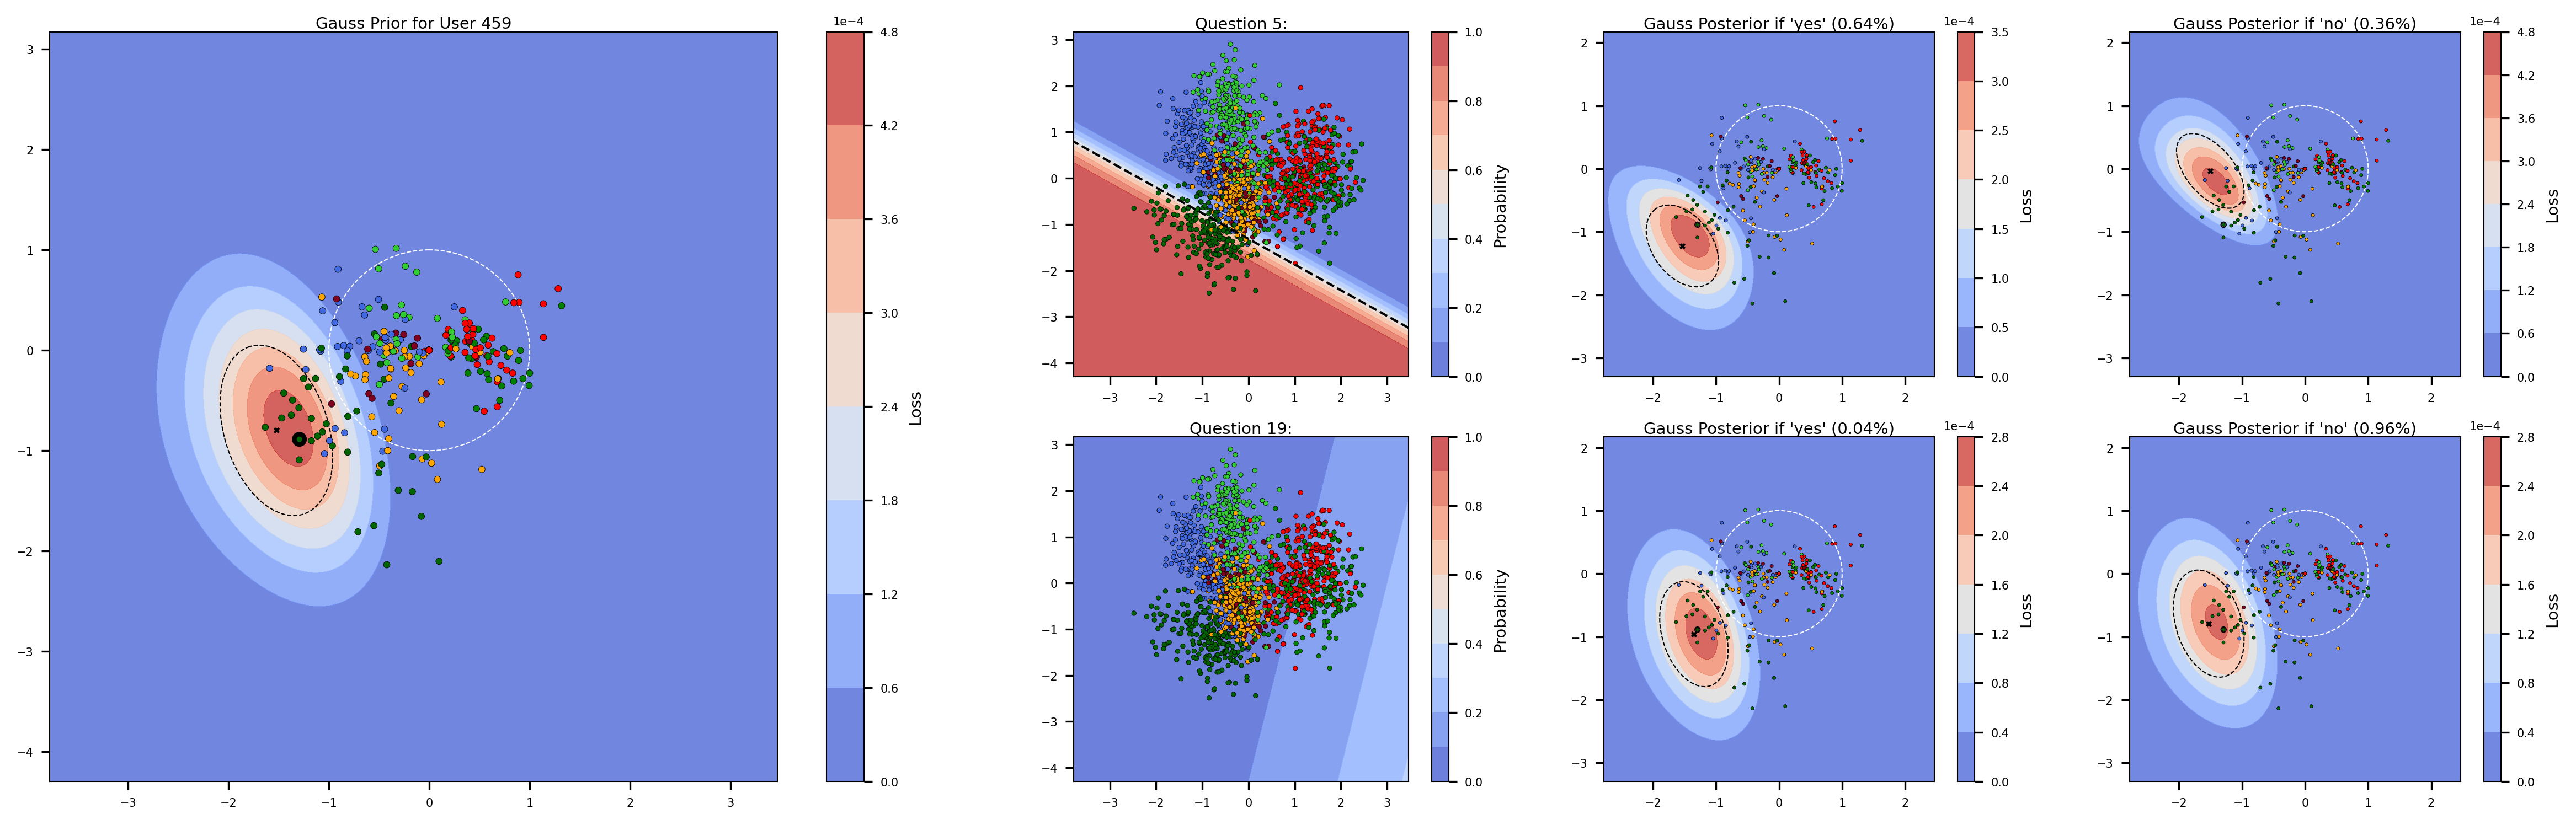

In [31]:
q3,q4 = 5,19
fig = demoFigure([q3,q4])
savefig(fig, f'PosteriorVariance_{n}_{q3}_{q4}')

## Running

In [32]:
%%time 

class RandomSelection(al.SelectionMethod):
    def __init__(self, use_cache=False):
        super().__init__(use_cache)
        self.RNG = np.random.default_rng(seed=0)

    def __str__(self):
        return 'RandomOrder'
    
    def compute_weights(self, given_answers=None, **kwargs):
        return self.RNG.random(len(self.open_index))

random  = RandomSelection()
Learner = al.ActiveLearner(ideal, random, train_reactions, test_reactions)

CPU times: user 1.86 s, sys: 1.17 s, total: 3.03 s
Wall time: 2.82 s


In [33]:
%%time
Learner.run(iterations=10, verbose=False)
Learner.evaluation

CPU times: user 168 ms, sys: 41.8 ms, total: 210 ms
Wall time: 202 ms


User Question     Value Counter  Pred-kNN User Pred-kNN  Base-kNN  \
0   459       63  0.999997     NaN  0.045259           0.0  0.020366   
1  1822       66  0.999969     NaN  0.045259        0.3125  0.020366   
2   393       48  0.999917     NaN  0.044612       0.09375  0.020259   
3   831       60  0.999868     NaN  0.044289           0.0  0.020582   
4   846        5  0.999774     NaN   0.04472        0.1875  0.020582   
5   530        6  0.999759     NaN  0.044073           0.0  0.020582   
6   865        1  0.999741     NaN   0.04569       0.03125   0.02069   
7   218       41  0.999566     NaN  0.046013           0.0   0.02069   
8   156       55  0.999557     NaN  0.046013       0.03125  0.020582   
9  1390        3  0.999533     NaN  0.047198           0.0  0.021013   

  User Base-kNN  Accuracy Expected Accuracy User Accuracy      RMSE  \
0           0.0  0.676966          0.682089      0.346667  0.450111   
1       0.09375  0.677168          0.681998      0.853333  0.449955   
2           0.0  0.677208          0.682193          0.76  0.449858   
3       0.03125  0.677057          0.682399          0.56   0.44989   
4        0.0625  0.677875           0.68235          0.76  0.449558   
5       0.03125  0.677771          0.682484           0.6  0.449582   
6        0.0625  0.678731          0.682454           0.8  0.449237   
7       0.03125  0.679094          0.682687      0.346667  0.449022   
8           0.0  0.678644          0.682959      0.813333  0.449379   
9       0.03125  0.679055          0.683402      0.426667  0.448925   

  Expected RMSE User RMSE                   Timestamp  
0      0.412375  0.604123  2024-06-05 13:08:15.784707  
1      0.412449  0.368183  2024-06-05 13:08:15.806847  
2      0.412256  0.407406  2024-06-05 13:08:15.827207  
3      0.412051  0.501511  2024-06-05 13:08:15.845909  
4      0.412078  0.421431  2024-06-05 13:08:15.864630  
5      0.411945  0.476372  2024-06-05 13:08:15.883091  
6      0.411931  0.375782  2024-06-05 13:08:15.902019  
7      0.411697  0.594709  2024-06-05 13:08:15.920590  
8      0.411451  0.383203  2024-06-05 13:08:15.939081  
9      0.410951  0.559294  2024-06-05 13:08:15.957325

In [34]:
%%time
Learner.run(iterations=1000, verbose=200)

Iteration 10: 508-3 gives 0.68%
Iteration 210: 1138-19 gives 0.71%
Iteration 410: 1399-50 gives 0.72%
Iteration 610: 995-72 gives 0.73%
Iteration 810: 401-34 gives 0.74%
CPU times: user 16.5 s, sys: 3.92 s, total: 20.4 s
Wall time: 19.8 s


In [37]:
%%time
Learner.run()
Learner.save()

Iteration 3930: 688-29 gives 0.79%
Iteration 4930: 1722-6 gives 0.79%
Iteration 5930: 944-66 gives 0.8%
Iteration 6930: 224-57 gives 0.8%
Iteration 7930: 1684-50 gives 0.81%
Iteration 8930: 1376-50 gives 0.81%
Iteration 9930: 107-48 gives 0.81%
Iteration 10930: 107-26 gives 0.81%
Iteration 11930: 138-32 gives 0.82%
Iteration 12930: 1722-64 gives 0.82%
Iteration 13930: 767-41 gives 0.82%
Iteration 14930: 1173-70 gives 0.82%
Iteration 15930: 52-60 gives 0.82%
Iteration 16930: 763-7 gives 0.82%
Iteration 17930: 122-66 gives 0.82%
Iteration 18930: 1593-27 gives 0.83%
Iteration 19930: 1467-8 gives 0.83%
Iteration 20930: 1134-19 gives 0.8%


TypeError: save() missing 2 required positional arguments: 'folder_name' and 'data_name'

In [24]:
%%time 
prior_probs = (ideal.likelihood_X * ideal.prior_X.reshape(-1,1)).sum(axis=0)
prior_gini  = 2 * prior_probs * (1-prior_probs)

fixgini = FixedOrder(fixed_order=list(prior_gini.sort_values(ascending=False).index), 
                        use_cache=True,
                        name='FixedGini')
Learner = ActiveLearner(ideal, fixgini, train_reactions, test_reactions)
Learner.run(verbose=2000)
Learner.save()

Iteration 0: 5-7 gives 0.68%
Iteration 2000: 1671-36 gives 0.78%
Iteration 4000: 1513-10 gives 0.79%
Iteration 6000: 1383-56 gives 0.79%
Iteration 8000: 1139-46 gives 0.8%
Iteration 10000: 895-30 gives 0.82%
Iteration 12000: 698-61 gives 0.83%
Iteration 14000: 456-1 gives 0.85%
Iteration 16000: 247-44 gives 0.86%
Iteration 18000: 95-43 gives 0.88%
Iteration 20000: 1828-74 gives 0.91%
CPU times: user 8min 34s, sys: 2min 13s, total: 10min 48s
Wall time: 10min 34s


In [11]:
%%time 
fasttrack = FixedOrder(fixed_order=list(statements.loc[statements['rapid']].index.astype(str)), 
                        use_cache=True,
                        name='FastTrack')
Learner = ActiveLearner(ideal, fasttrack, train_reactions, test_reactions)
Learner.run()
Learner.save()

Iteration 0: 5-1 gives 0.68%
Iteration 500: 1411-2 gives 0.71%
Iteration 1000: 819-5 gives 0.73%
Iteration 1500: 247-7 gives 0.76%
Iteration 2000: 1671-9 gives 0.79%
Iteration 2500: 1211-12 gives 0.79%
Iteration 3000: 631-15 gives 0.8%
Iteration 3500: 95-23 gives 0.8%
Iteration 4000: 1513-25 gives 0.8%
Iteration 4500: 982-27 gives 0.8%
Iteration 5000: 382-31 gives 0.8%
Iteration 5500: 1828-35 gives 0.8%
Iteration 6000: 1383-37 gives 0.8%
Iteration 6500: 762-43 gives 0.8%
Iteration 7000: 187-46 gives 0.8%
Iteration 7500: 1632-48 gives 0.8%
Iteration 8000: 1139-58 gives 0.8%
Iteration 8500: 530-63 gives 0.8%
CPU times: user 2min 37s, sys: 50.7 s, total: 3min 28s
Wall time: 3min 22s


In [23]:
%%time 
default = FixedOrder(fixed_order=list(statements.index.astype(str)), 
                     use_cache=True,
                     name='DefaultOrder')
Learner = ActiveLearner(ideal, default, train_reactions, test_reactions)
Learner.run(verbose=False)
Learner.save()

CPU times: user 8min 39s, sys: 2min 11s, total: 10min 51s
Wall time: 10min 37s


In [20]:
%%time 
class Neighborhood(SelectionMethod):
    def __init__(self, model, train_set, k_neighbors=10, base=False):
        super().__init__(model=model, use_cache=True, name=f"{['Full', 'Base'][base]}KNN")
        self.candidates = NearestCandidates(train_set, k=k_neighbors)
        self.k = k_neighbors
        self.base = base
    
    def compute_weights(self, given_answers): 
        if self.base:
            neighbors = self.candidates.recommend(given_answers)
        else:
            user_pred = self.model.predict_user(self.user)
            neighbors = self.candidates.recommend(user_pred)
        return self.candidates.train_set.loc[neighbors, self.open_index].std(axis=0).values
    
asknn = Neighborhood(model=ideal, train_set=train_reactions, k_neighbors=32)
Learner = ActiveLearner(ideal, asknn, train_reactions, test_reactions)
Learner.run()
Learner.save()

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.1 µs


In [21]:
asknnbase = Neighborhood(model=ideal, train_set=train_reactions, k_neighbors=32, base=True)
Learner = ActiveLearner(ideal, asknnbase, train_reactions, test_reactions)
Learner.run()
Learner.save()

Iteration 0: 5-28 gives 0.68%
Iteration 1000: 1164-58 gives 0.74%
Iteration 2000: 241-17 gives 0.8%
Iteration 3000: 1132-4 gives 0.81%
Iteration 4000: 1711-9 gives 0.83%
Iteration 5000: 1015-24 gives 0.85%
Iteration 6000: 693-9 gives 0.87%
Iteration 7000: 95-59 gives 0.89%
Iteration 8000: 1519-48 gives 0.9%
Iteration 9000: 977-26 gives 0.92%
Iteration 10000: 224-56 gives 0.93%
Iteration 11000: 1364-49 gives 0.94%
Iteration 12000: 1745-40 gives 0.95%
Iteration 13000: 45-50 gives 0.95%
Iteration 14000: 1632-35 gives 0.96%
Iteration 15000: 799-33 gives 0.97%
Iteration 16000: 1840-62 gives 0.97%
Iteration 17000: 171-29 gives 0.97%
Iteration 18000: 460-20 gives 0.97%
Iteration 19000: 944-62 gives 0.96%
Iteration 20000: 1365-11 gives 0.95%
Iteration 21000: 1649-6 gives 0.95%


In [22]:
%%time 
class Uncertainty(al.SelectionMethod):
    def __str__(self):
        return 'Uncertainty'
    
    def compute_weights(self, given_answers): 
        P_Yn1_X = self.model.likelihood_X.loc[:, self.open_index]
        P_X_Yi = self.model.posterior_X(given_answers).reshape(-1,1) ## (40000,1)
        P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
        P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
        return 2*P_Yn1_Yi*(1-P_Yn1_Yi)
    
uncertainty = Uncertainty(use_cache=True, model=ideal)
Learner = al.ActiveLearner(ideal, uncertainty, train_reactions, test_reactions)
Learner.run()
Learner.save()


Iteration 0: 5-7 gives 0.68%
Iteration 1000: 1497-23 gives 0.76%
Iteration 2000: 107-13 gives 0.8%
Iteration 3000: 1658-55 gives 0.82%
Iteration 4000: 1018-33 gives 0.84%
Iteration 5000: 384-21 gives 0.86%
Iteration 6000: 357-39 gives 0.87%
Iteration 7000: 828-21 gives 0.89%
Iteration 8000: 1660-50 gives 0.9%
Iteration 9000: 90-63 gives 0.91%
Iteration 10000: 1524-64 gives 0.92%
Iteration 11000: 698-62 gives 0.94%
Iteration 12000: 717-60 gives 0.95%
Iteration 13000: 1417-10 gives 0.96%
Iteration 14000: 308-13 gives 0.97%
Iteration 15000: 1609-37 gives 0.98%
Iteration 16000: 509-13 gives 0.98%
Iteration 17000: 1064-72 gives 0.99%
Iteration 18000: 1172-40 gives 0.99%
Iteration 19000: 1722-55 gives 1.0%
Iteration 20000: 1032-63 gives 1.0%
Iteration 21000: 1371-43 gives 1.0%
CPU times: user 11min 6s, sys: 2min 44s, total: 13min 50s
Wall time: 13min 34s


In [9]:
%%time 

class PosteriorRMSE(al.SelectionMethod):
    def __str__(self):
        return 'PosteriorRMSE'

    def compute_weights(self, given_answers): 
        P_Yn1_X = ideal.likelihood_X.loc[:,self.open_index].values ## (40000, 45)
        P_Yn0_X = 1 - P_Yn1_X
        P_X_Yi = ideal.posterior_X(given_answers) ## (40000,1)

        P_XYn0_Yi = P_Yn0_X * P_X_Yi ## (40000, 45)
        P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
        assert np.allclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5), "X Posteriors don't sum to 1"

        P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
        # P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
        # assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

        P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
        P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

        P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
        P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
        # P_X_Yin1  = P_XYn1_Yi / P_Yn1_Yi ## (40000, 45)
        # P_X_Yin0  = P_XYn0_Yi / P_Yn0_Yi ## (40000, 45)
        assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
        assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

        P_Yn1_Yin1 = np.tensordot(P_Yn1_X, P_X_Yin1, axes=[0,0]) ## (45,45)
        P_Yn1_Yin0 = np.tensordot(P_Yn1_X, P_X_Yin0, axes=[0,0]) ## (45,45)
        # P_Yn0_Yin1 = np.tensordot(P_Yn0_X, P_X_Yin1, axes=[0,0]) ## (45,45)
        # P_Yn0_Yin0 = np.tensordot(P_Yn0_X, P_X_Yin0, axes=[0,0]) ## (45,45)
        # assert np.allclose(P_Yn1_Yin1 + P_Yn0_Yin1, 1, rtol=1e-5)
        # assert np.allclose(P_Yn1_Yin0 + P_Yn0_Yin0, 1, rtol=1e-5)
        np.fill_diagonal(P_Yn1_Yin1, 1)
        np.fill_diagonal(P_Yn1_Yin0, 0)

        ### PRIOR GINI (FOR ALL REMAINING QUESTIONS)
        prior_gini = 2 * (P_Yn1_Yi * (1-P_Yn1_Yi))
        ### POSTERIOR GINI (If Yn=0) 
        gini_Yn0 = (2 * (1-P_Yn1_Yin0) * P_Yn1_Yin0).sum(axis=0)
        ### POSTERIOR GINI (If Yn=1) 
        gini_Yn1 = (2 * (1-P_Yn1_Yin1) * P_Yn1_Yin1).sum(axis=0)

        posterior_gini_sum = P_Yn1_Yi*gini_Yn1 + (1-P_Yn1_Yi)*gini_Yn0
        posterior_rmse_loss = prior_gini.sum() - posterior_gini_sum
        return posterior_rmse_loss
    
postrmse = PosteriorRMSE(use_cache=True, model=ideal)
Learner = ActiveLearner(ideal, postrmse, train_reactions, test_reactions)
Learner.run(verbose=2000)
Learner.save()

Iteration 0: 5-65 gives 0.68%
Iteration 2000: 9-16 gives 0.81%
Iteration 4000: 865-17 gives 0.84%
Iteration 6000: 94-20 gives 0.87%
Iteration 8000: 67-0 gives 0.9%
Iteration 10000: 1609-58 gives 0.92%
Iteration 12000: 456-42 gives 0.95%
Iteration 14000: 1138-41 gives 0.97%
Iteration 16000: 540-71 gives 0.98%
Iteration 18000: 37-13 gives 0.99%
Iteration 20000: 900-25 gives 1.0%
CPU times: user 1h 30min 15s, sys: 5min 4s, total: 1h 35min 19s
Wall time: 29min 54s


In [35]:
# %%time 

# class PosteriorKNN(al.SelectionMethod):
#     def __init__(self, model, train_set, k_neighbors=10, sample_factor=20):
#         super().__init__(model=model, use_cache=True, name="PosteriorKNN")
#         self.candidates = NearestCandidates(train_set, k=k_neighbors)
#         self.k = k_neighbors
#         self.sample_factor = sample_factor

#     def compute_weights(self, given_answers): 
#         P_Yn1_X = self.model.likelihood_X.loc[:,self.open_index].values ## (40000, 45)
#         P_X_Yi = self.model.posterior_X(given_answers) ## (40000,1)

#         P_XYn0_Yi = (1 - P_Yn1_X) * P_X_Yi ## (40000, 45)
#         P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
#         assert np.allclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5), "X Posteriors don't sum to 1"

#         P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
#         # P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
#         # assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

#         P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
#         mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
#         P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

#         P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
#         mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
#         P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
#         # P_X_Yin1  = P_XYn1_Yi / P_Yn1_Yi ## (40000, 45)
#         # P_X_Yin0  = P_XYn0_Yi / P_Yn0_Yi ## (40000, 45)
#         assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
#         assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

#         P_Yn1_Yin1 = np.tensordot(P_Yn1_X, P_X_Yin1, axes=[0,0]) ## (45,45)
#         P_Yn1_Yin0 = np.tensordot(P_Yn1_X, P_X_Yin0, axes=[0,0]) ## (45,45)
#         # P_Yn0_Yin1 = np.tensordot(P_Yn0_X, P_X_Yin1, axes=[0,0]) ## (45,45)
#         # P_Yn0_Yin0 = np.tensordot(P_Yn0_X, P_X_Yin0, axes=[0,0]) ## (45,45)
#         # assert np.allclose(P_Yn1_Yin1 + P_Yn0_Yin1, 1, rtol=1e-5)
#         # assert np.allclose(P_Yn1_Yin0 + P_Yn0_Yin0, 1, rtol=1e-5)
#         np.fill_diagonal(P_Yn1_Yin1, 1)
#         np.fill_diagonal(P_Yn1_Yin0, 0)

#         ### FIRST compute PRIOR KNN Variance
#         factor = 20
#         n_samples = self.user.isna().sum()*factor
#         predictions = self.model.predict_user(user)
#         indices = self.candidates.recommend(predictions)
#         prior = self.candidates.probabilistic(pd.DataFrame(predictions).T, n_samples=n_samples)

#         ### Now for the POSTERIOR KNN variance (given Yn=1)
#         pseudo_answers_Y1 = pd.DataFrame([self.user]*len(self.open_index))
#         pseudo_answers_Y1.index = self.open_index
#         pseudo_answers_Y1.loc[:,self.open_index] = P_Yn1_Yin1.T
#         result_Y1 = self.candidates.probabilistic(pseudo_answers_Y1, n_samples=n_samples)

#         ### Now for the POSTERIOR KNN variance (given Yn=0)
#         pseudo_answers_Y0 = pd.DataFrame([self.user]*len(self.open_index))
#         pseudo_answers_Y0.index = self.open_index
#         pseudo_answers_Y0.loc[:,self.open_index] = P_Yn1_Yin0.T
#         result_Y0 = self.candidates.probabilistic(pseudo_answers_Y0, n_samples=n_samples)

#         ### Now compute the expected loss of POSTERIOR KNN 
#         posterior_knn = P_Yn1_Yi*result_Y1.loc[self.open_index, 'variance'] + (1-P_Yn1_Yi)*result_Y0.loc[self.open_index, 'variance']
#         posterior_knn_loss = 100*(prior.iloc[0,1] - posterior_knn).values
#         return posterior_knn_loss
    
# postknn = PosteriorKNN(model=ideal, train_set=train_reactions)
# Learner = al.ActiveLearner(ideal, postknn, train_reactions, test_reactions.iloc[:2])
# Learner.run(verbose=1)
# # Learner.save()

In [34]:
%%time 

class PosteriorKNN(al.SelectionMethod):
    def __init__(self, model, train_set, k_neighbors=10, sample_factor=20):
        super().__init__(model=model, use_cache=True, name="PosteriorKNN")
        self.candidates = NearestCandidates(train_set, k=k_neighbors)
        self.k = k_neighbors

    def compute_weights(self, given_answers): 
        P_Yn1_X = self.model.likelihood_X.loc[:,self.open_index].values ## (40000, 45)
        P_X_Yi = self.model.posterior_X(given_answers) ## (40000,1)

        P_XYn0_Yi = (1 - P_Yn1_X) * P_X_Yi ## (40000, 45)
        P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
        assert np.allclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5), "X Posteriors don't sum to 1"

        P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
        # P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
        # assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

        P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
        P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

        P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
        P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
        # P_X_Yin1  = P_XYn1_Yi / P_Yn1_Yi ## (40000, 45)
        # P_X_Yin0  = P_XYn0_Yi / P_Yn0_Yi ## (40000, 45)
        assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
        assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

        P_Yn1_Yin1 = np.tensordot(P_Yn1_X, P_X_Yin1, axes=[0,0]) ## (45,45)
        P_Yn1_Yin0 = np.tensordot(P_Yn1_X, P_X_Yin0, axes=[0,0]) ## (45,45)
        # P_Yn0_Yin1 = np.tensordot(P_Yn0_X, P_X_Yin1, axes=[0,0]) ## (45,45)
        # P_Yn0_Yin0 = np.tensordot(P_Yn0_X, P_X_Yin0, axes=[0,0]) ## (45,45)
        # assert np.allclose(P_Yn1_Yin1 + P_Yn0_Yin1, 1, rtol=1e-5)
        # assert np.allclose(P_Yn1_Yin0 + P_Yn0_Yin0, 1, rtol=1e-5)
        np.fill_diagonal(P_Yn1_Yin1, 1)
        np.fill_diagonal(P_Yn1_Yin0, 0)

        neighbors = self.candidates.recommend(given_answers)
        self.candidates.train_set.loc[neighbors, self.open_index].std(axis=0).sum()
    
    
postknn = PosteriorKNN(model=ideal, train_set=train_reactions)
Learner = al.ActiveLearner(ideal, postknn, train_reactions, test_reactions.iloc[:2])
Learner.run(verbose=1)
# Learner.save()

User Question      Value  Counter  Pred-kNN User Pred-kNN  Base-kNN  \
0      5       41  34.133297        0   0.03125        0.0625    0.0625   
1      5       19  35.032641        1       0.0           0.0   0.09375   
2      9       41  34.133297        0    0.0625           0.0  0.078125   
3      9       49  33.501161        1    0.0625           0.0  0.046875   
4      9       40  33.228354        2    0.0625           0.0   0.03125   
..   ...      ...        ...      ...       ...           ...       ...   
131    9       61 -27.479796       59  0.796875          0.75    0.6875   
132    9       43 -30.980816       60    0.8125       0.78125  0.734375   
133    9       53 -32.855587       61    0.8125       0.78125  0.734375   
134    5       42 -35.622221       72  0.828125       0.84375  0.734375   
135    5       38 -33.253841       73   0.84375         0.875      0.75   

    User Base-kNN  Accuracy Expected Accuracy User Accuracy      RMSE  \
0         0.03125  0.606667          0.682089      0.786667  0.489886   
1         0.09375  0.571441          0.678009      0.716216  0.509068   
2         0.09375  0.637991           0.69544      0.426667  0.475312   
3         0.03125  0.640874          0.735355      0.432432  0.483867   
4             0.0  0.643836          0.743887      0.438356  0.491721   
..            ...       ...               ...           ...       ...   
131       0.59375     0.875          0.633838          0.75  0.347124   
132        0.6875  0.866667          0.635588      0.733333  0.347511   
133        0.6875  0.892857           0.64556      0.785714  0.347434   
134       0.78125  0.884615          0.666654           1.0  0.344598   
135        0.8125  0.884615          0.655849           1.0   0.35869   

    Expected RMSE User RMSE                   Timestamp  
0        0.412375  0.405192  2024-02-12 20:53:04.510385  
1        0.415824  0.443555  2024-02-12 20:53:13.895341  
2        0.400235   0.57458  2024-02-12 20:53:23.556577  
3        0.363842  0.591691  2024-02-12 20:53:32.971029  
4        0.354337  0.607399  2024-02-12 20:53:42.204859  
..            ...       ...                         ...  
131      0.449812  0.439241  2024-02-12 21:01:09.784667  
132      0.448021  0.440015  2024-02-12 21:01:10.203681  
133      0.442459   0.43986  2024-02-12 21:01:10.565676  
134      0.431984  0.255008  2024-02-12 21:01:10.626319  
135      0.442573  0.283192  2024-02-12 21:01:10.681186  

[136 rows x 15 columns]

In [28]:
%%time 

class PosteriorVariance(SelectionMethod):
    def __str__(self):
        return 'PosteriorVariance'

    def compute_weights(self, given_answers): 
        P_Yn1_X = ideal.likelihood_X.loc[:,self.open_index].values ## (40000, 45)
        P_Yn0_X = 1 - P_Yn1_X
        P_X_Yi = ideal.posterior_X(given_answers) ## (40000,1)

        P_XYn0_Yi = P_Yn0_X * P_X_Yi ## (40000, 45)
        P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
        assert np.all(np.isclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5)), "X Posteriors don't sum to 1"

        P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
        P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
        assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

        P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
        P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

        P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
        mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
        P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
        assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
        assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

        ### FIRST compute PRIOR variance
        mean = (P_X_Yi * ideal.X).sum(axis=0)
        distance_to_mean = ((ideal.X - mean)**2).sum(axis=1).reshape(-1,1)
        prior_var = (distance_to_mean * P_X_Yi).sum()

        ### Alternative computation for prior
        mean = (ideal.X[:, :, np.newaxis] * P_X_Yi[:, np.newaxis, :]).sum(axis=0) ## (40000,2)
        distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1) ## (40000,1)
        prior_var_test = (distance_to_mean * P_X_Yi).sum(axis=0) ## (1,)
        assert np.isclose(prior_var, prior_var_test)

        ### Now for the POSTERIOR variance (given Yn=1)
        mean = (ideal.X[:, :, np.newaxis] * P_X_Yin1[:, np.newaxis, :]).sum(axis=0) ## (40000,2)
        distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1) ## (40000,45)
        var_Yn1 = (distance_to_mean * P_X_Yin1).sum(axis=0) ## (45,)

        ### Now for the POSTERIOR variance (given Yn=0)
        mean = (ideal.X[:, :, np.newaxis] * P_X_Yin0[:, np.newaxis, :]).sum(axis=0)
        distance_to_mean = ((ideal.X[:, :, np.newaxis] - mean)**2).sum(axis=1)
        var_Yn0 = (distance_to_mean * P_X_Yin0).sum(axis=0)

        posterior_var = P_Yn1_Yi*var_Yn1 + P_Yn0_Yi*var_Yn0
        posterior_var_loss = prior_var - posterior_var

        return posterior_var_loss
    
postvar = PosteriorVariance(use_cache=True, model=ideal)
Learner = ActiveLearner(ideal, postvar, train_reactions, test_reactions)
Learner.run(verbose=2000)
Learner.save()

Iteration 0: 5-36 gives 0.68%
Iteration 2000: 1399-28 gives 0.81%
Iteration 4000: 530-49 gives 0.82%
Iteration 6000: 790-5 gives 0.83%
Iteration 8000: 846-2 gives 0.83%
Iteration 10000: 628-46 gives 0.83%
Iteration 12000: 300-43 gives 0.83%
Iteration 14000: 1601-33 gives 0.83%
Iteration 16000: 167-22 gives 0.84%
Iteration 18000: 1497-67 gives 0.84%
Iteration 20000: 977-30 gives 0.84%
CPU times: user 20min 27s, sys: 5min 46s, total: 26min 14s
Wall time: 26min 9s


## Results

In [39]:
folder_name = 'Smartvote'
data_name = 'Binary'
suffix = 'candidates'

methods = ['RandomOrder', 
           'FullKNN',
           'BaseKNN',
           'FixedGini', 
           'DefaultOrder',
           'Uncertainty', 
           'PosteriorRMSE', 
           'PosteriorVariance',
           'FastTrack'
        ]

metrics = ['Accuracy', 'RMSE']
models  = ['IDEAL']

results = {selector: pd.read_csv(f'../../results/ALVAA/{folder_name}_{data_name}_IDEAL_{selector}_{suffix}.csv', index_col=0) for selector in methods}

# experiment = pd.read_csv(f'{method_path}/IRT/metrics.csv', index_col=0)
# results['Experiment'] = experiment.loc[(experiment['Dataset'] == folder_name) 
#                         & (experiment['Datatype'] == data_name) 
#                         & (experiment['Evaluation Set'] == 'Test') 
#                         & (experiment['Task'] == 'Impute')
#                         & (experiment['Train Sparsity'] == 0)
#                         ].set_index('Evaluation Sparsity'
#                         ).loc[:,metrics].sort_index()
# results['Experiment'].index = test_reactions.size * (1 - results['Experiment'].index/100)

In [40]:
def showResults(results, **kwargs):
    params = {'title': None, 
              'metric': 'Accuracy', 
              'xmin': 0, 'xmax':None, 
              'ylim':(0.5,1), 
              'ncol':3, 
              'linekwargs': {},
              'savefig':False, 'suffix': 'results',
              'singleUser': False,
              'includeGiven': False,
              'figax': None,
              'legend': True}
    
    params.update(kwargs)
    n_queries = [test_reactions.size, test_reactions.shape[1]][params['singleUser']]
    if params['title'] is None:
        params['title'] = f"{params['metric']} when predicting {['the remaining', 'all'][params['includeGiven']]} values {['for all users', 'per user'][params['singleUser']]}"
    xmin, xmax = params['xmin'], params['xmax'] if params['xmax'] is not None else n_queries-1
    best_value = {'Accuracy': 1, 'RMSE':0, 'Candidates':1}
    function = lambda data: (best_value[params['metric']]-data) * data.index/n_queries + data
    if params['figax'] is None:
        fig, ax = plt.subplots(figsize=(vis.beamerwidth,vis.beamerheight))
    else:
        fig, ax = params['figax']
    for i, method in enumerate(results.keys()):
        result = results[method].copy()
        mean = result[params['metric']]
        if params['singleUser']:
            result['Counter'] = result.groupby('User').cumcount()
            # Pivot the DataFrame
            pivot = result.pivot(index='User', columns='Counter', values=f"User {params['metric']}")
            if params['includeGiven']:
                pivot = (best_value[params['metric']]-pivot) * pivot.columns/n_queries + pivot
            mean = pivot.mean(axis=0)
            std = pivot.std(axis=0)
            s = np.sqrt(len(pivot))
            ax.fill_between(mean.index, mean-std/s, mean+std/s, color=f'C{i}', alpha=0.4)
        elif params['includeGiven']:
            mean = (best_value[params['metric']]-mean) * mean.index/n_queries + mean
        ax.plot(mean.index, mean.values, color=f'C{i}', label=method, lw=1, **params['linekwargs'])
        if method == 'FastTrack':
            ax.axhline(mean.iloc[-1], color=f'C{i}', linestyle='--', lw=0.5)
    ax.set(xlim=(xmin, xmax),
        ylim=params['ylim'],
        xlabel='Query',
        ylabel=params['metric'],
        title=params['title'])
    ax.grid()
    if params['legend']:
        ax.legend(ncol=params['ncol'],facecolor='white', framealpha=1)
    # Create a legend for the first subplot and place it outside of the axes
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, .5))
    fig.tight_layout()

    if params['savefig']:
        savefig(fig, f"{params['metric']}_{['','SingleUser_'][params['singleUser']]}{['','includeGiven_'][params['includeGiven']]}{params['suffix']}")

    return fig, ax

### Comparing Base-kNN and Pred-kNN

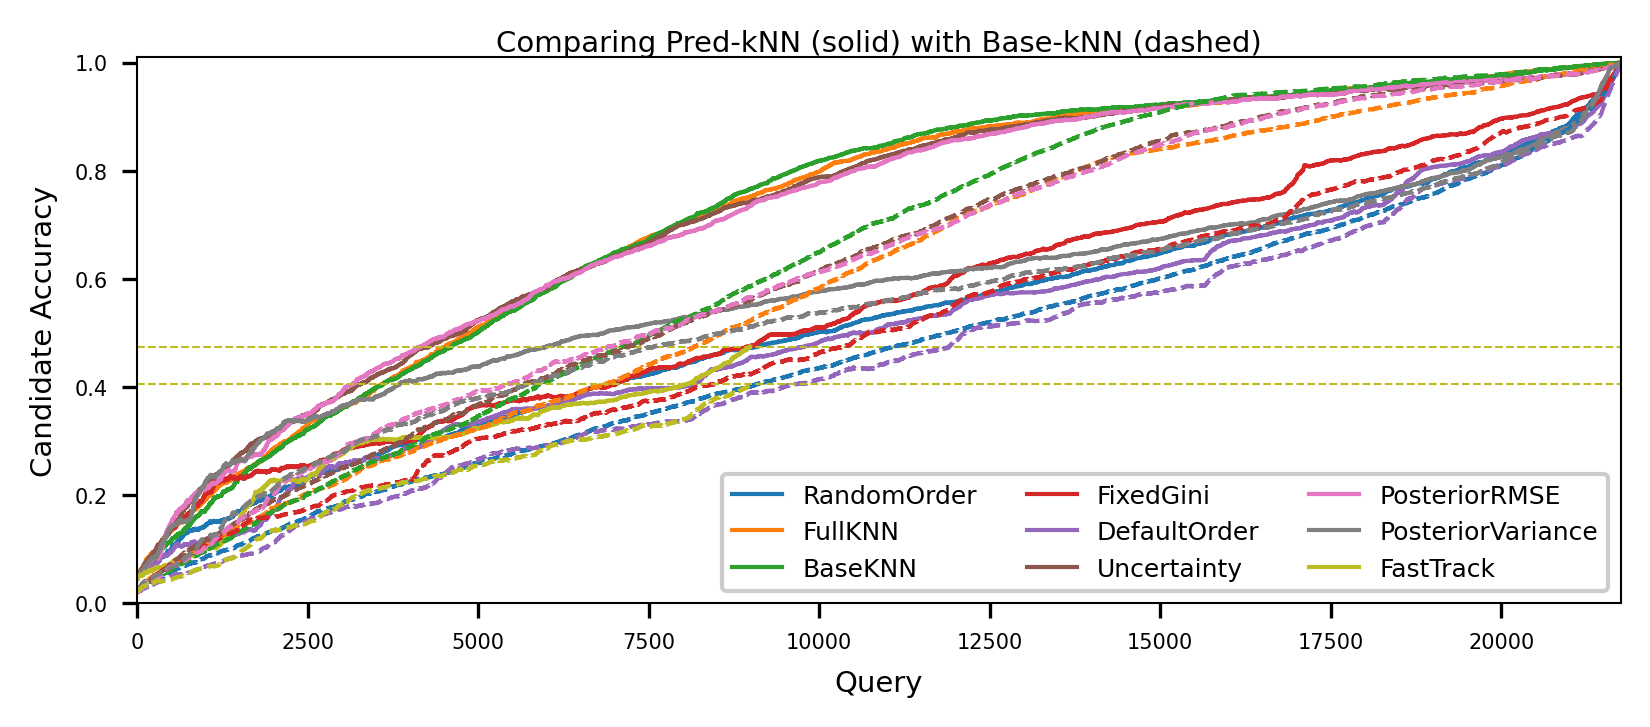

In [42]:
fig, ax = showResults(results, ylim=(0.0,1.01), metric='Pred-kNN')
fig, ax = showResults(results, ylim=(0.0,1.01), legend=False, figax=(fig, ax), ncol=4, linekwargs={'linestyle':'--'}, metric='Base-kNN')
ax.set(title='Comparing Pred-kNN (solid) with Base-kNN (dashed)',
       ylabel='Candidate Accuracy')
savefig(fig, "KNN_ComparingBaseAndPred")

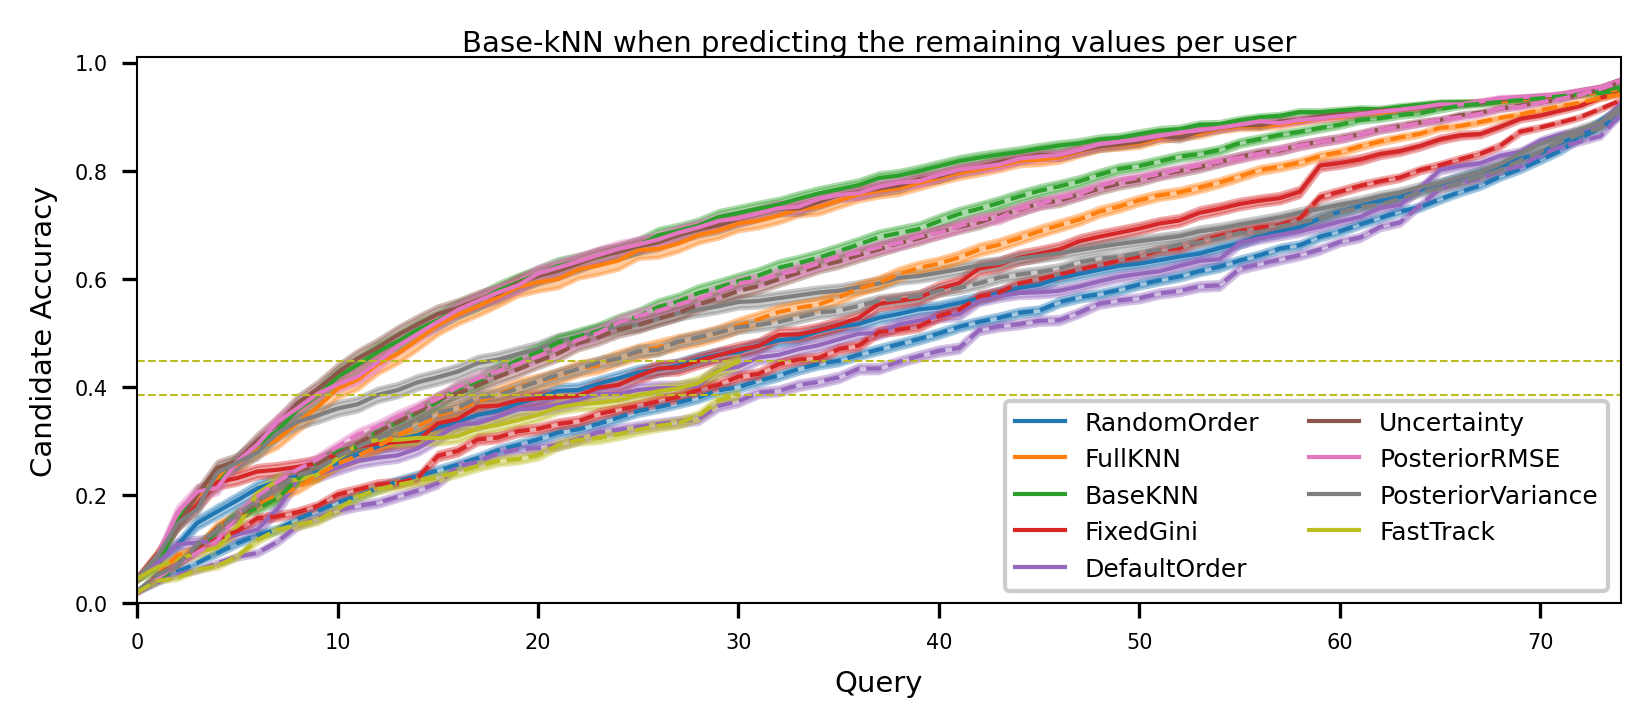

In [43]:
fig, ax = showResults(results, ylim=(0.0,1.01),ncol=2, metric='Pred-kNN', singleUser=True)
fig, ax = showResults(results, ylim=(0.0,1.01), legend=False, singleUser=True, figax=(fig, ax), linekwargs={'linestyle':'--'}, metric='Base-kNN')
ax.set(#title='Comparing Pred-kNN (solid) with Base-kNN (dashed)',
       ylabel='Candidate Accuracy')
savefig(fig, "KNN_ComparingBaseAndPred_SingleUser")

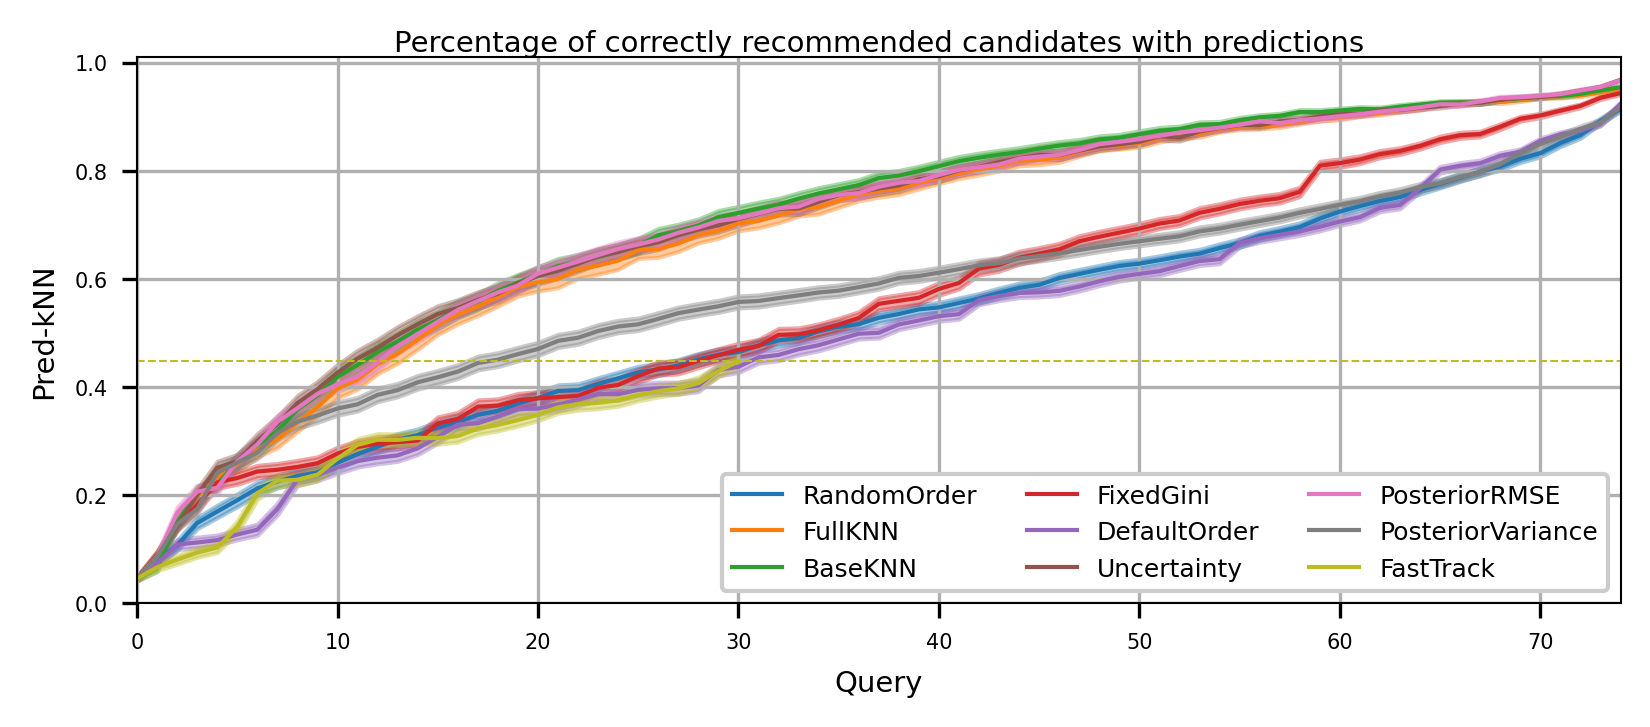

In [44]:
_fig, ax = showResults(results, ylim=(0.0,1.01), metric='Pred-kNN', singleUser=True)
_ = ax.set_title('Percentage of correctly recommended candidates with predictions')

### Accuracy and RMSE

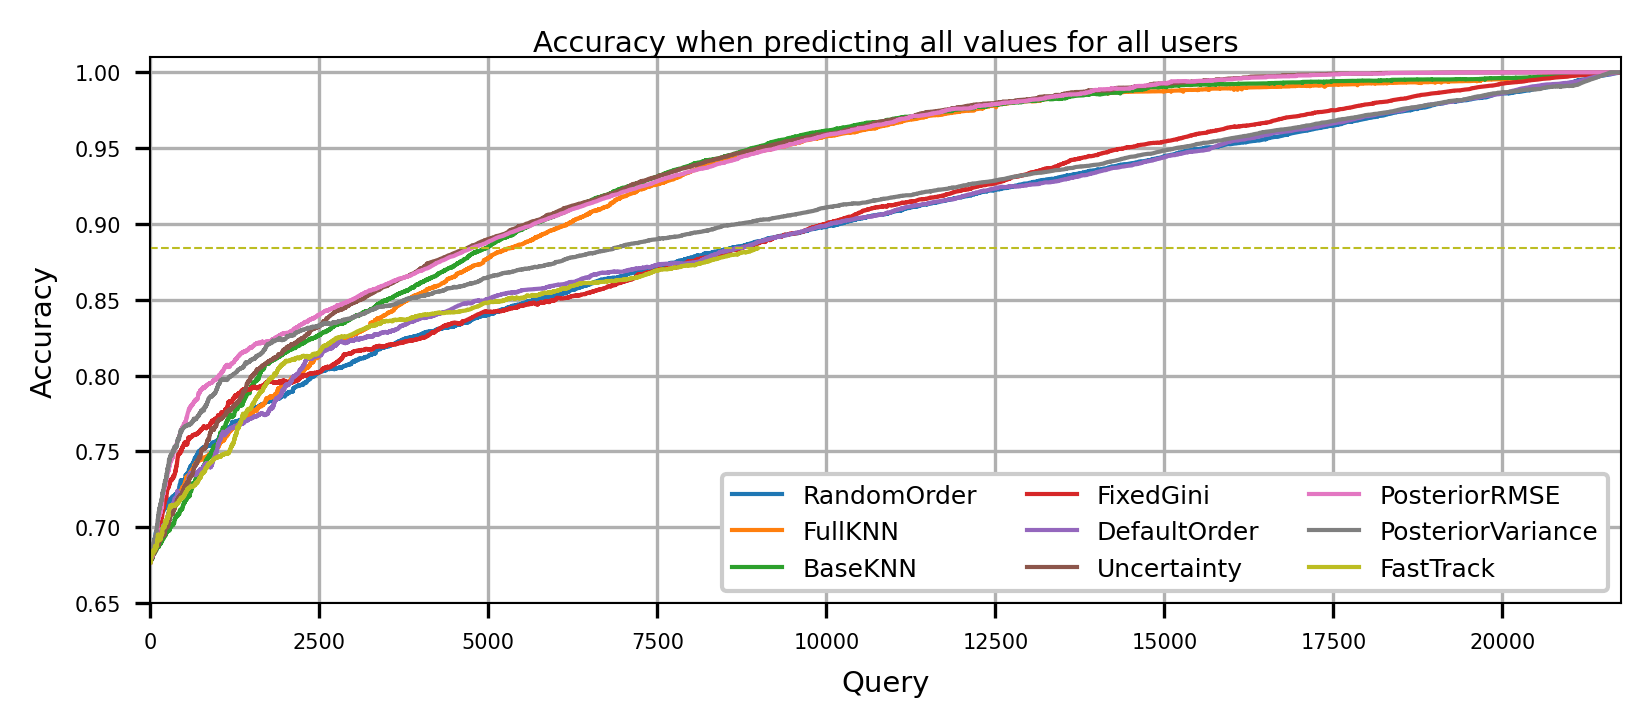

In [45]:
fig, ax = showResults(results, ylim=(0.65,1.01), includeGiven=True, savefig=True)

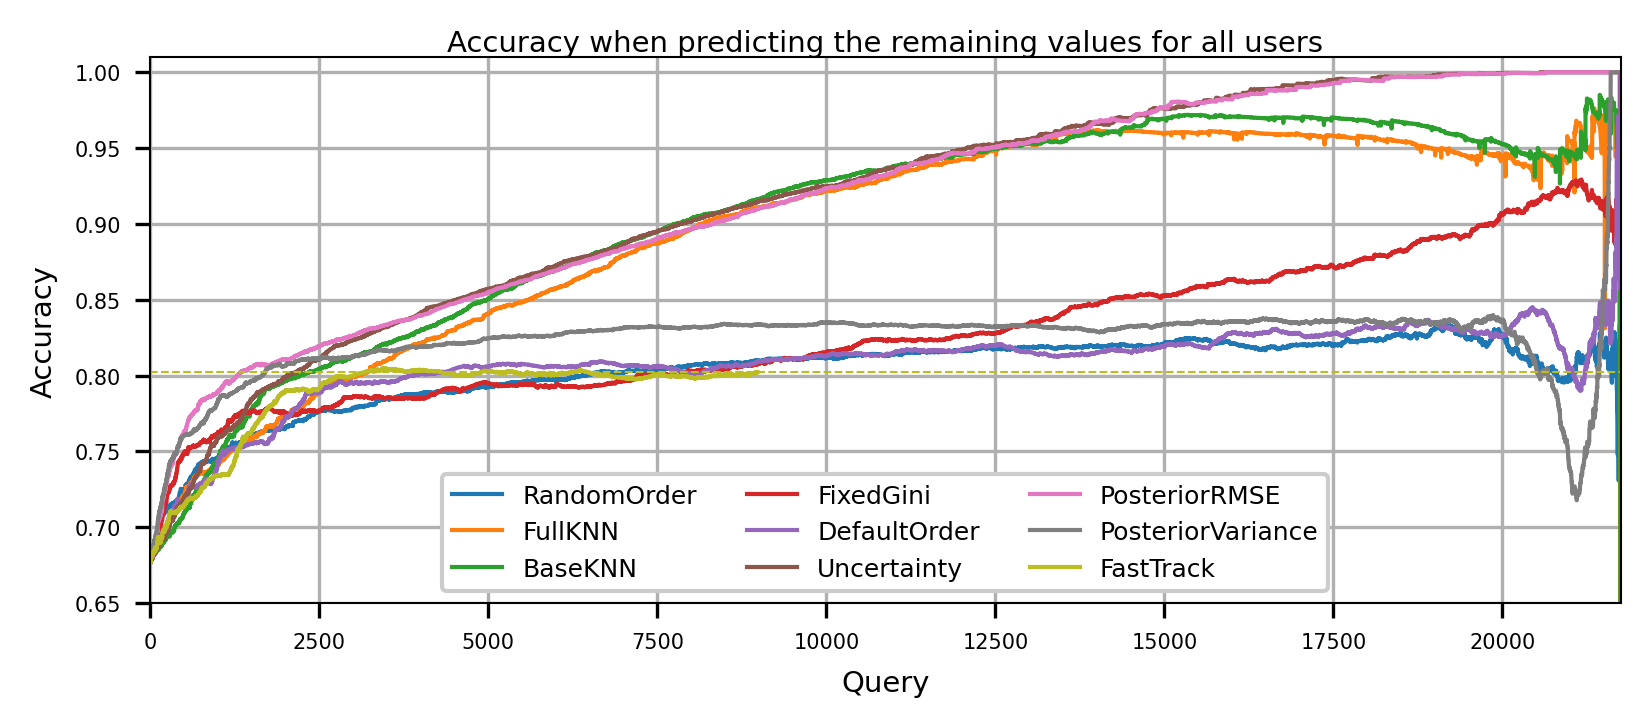

In [60]:
fig, ax = showResults(results, ylim=(0.65,1.01), savefig=True)

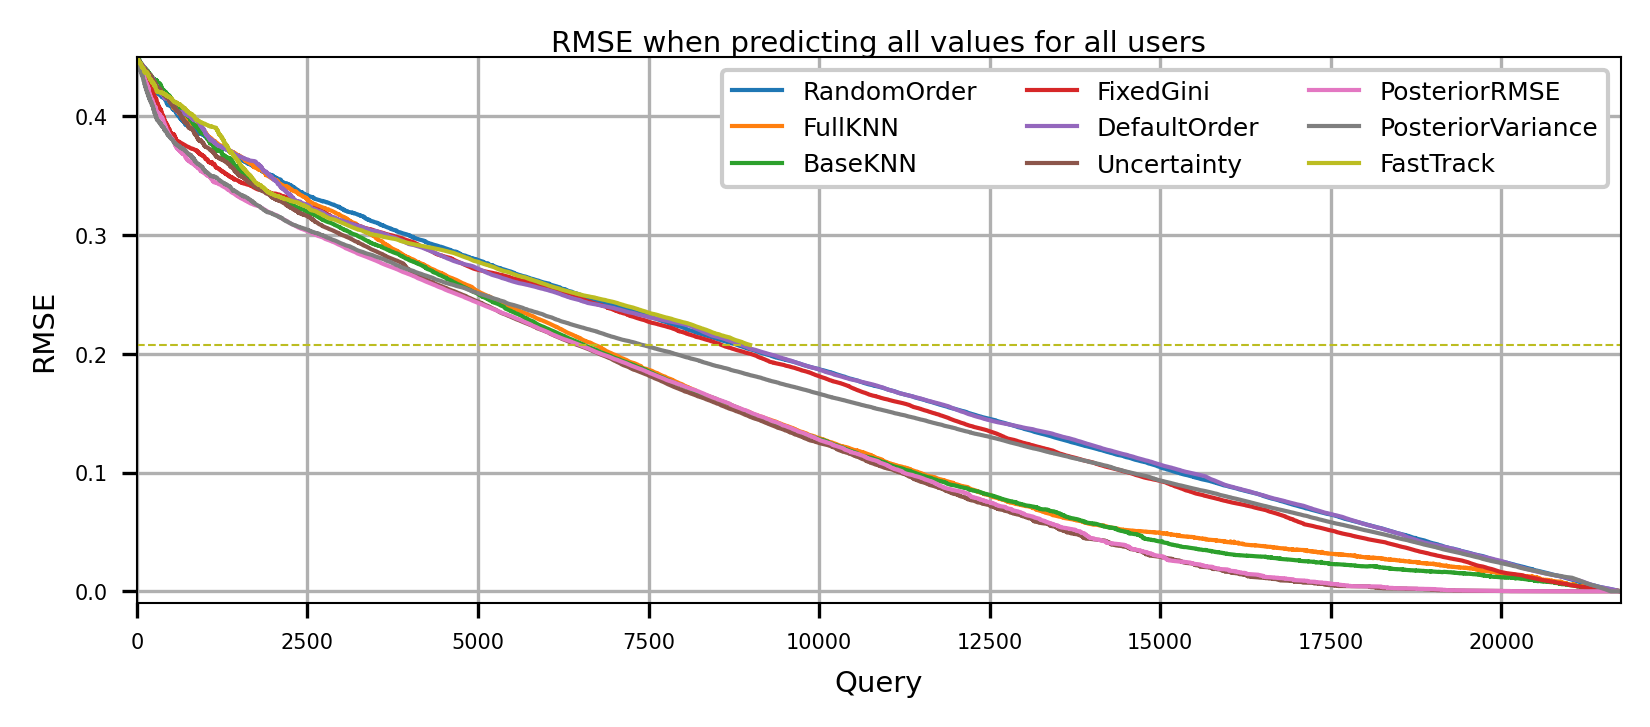

In [22]:
fig, ax = showResults(results, ylim=(-.01, 0.45), savefig=True, includeGiven=True, metric='RMSE')

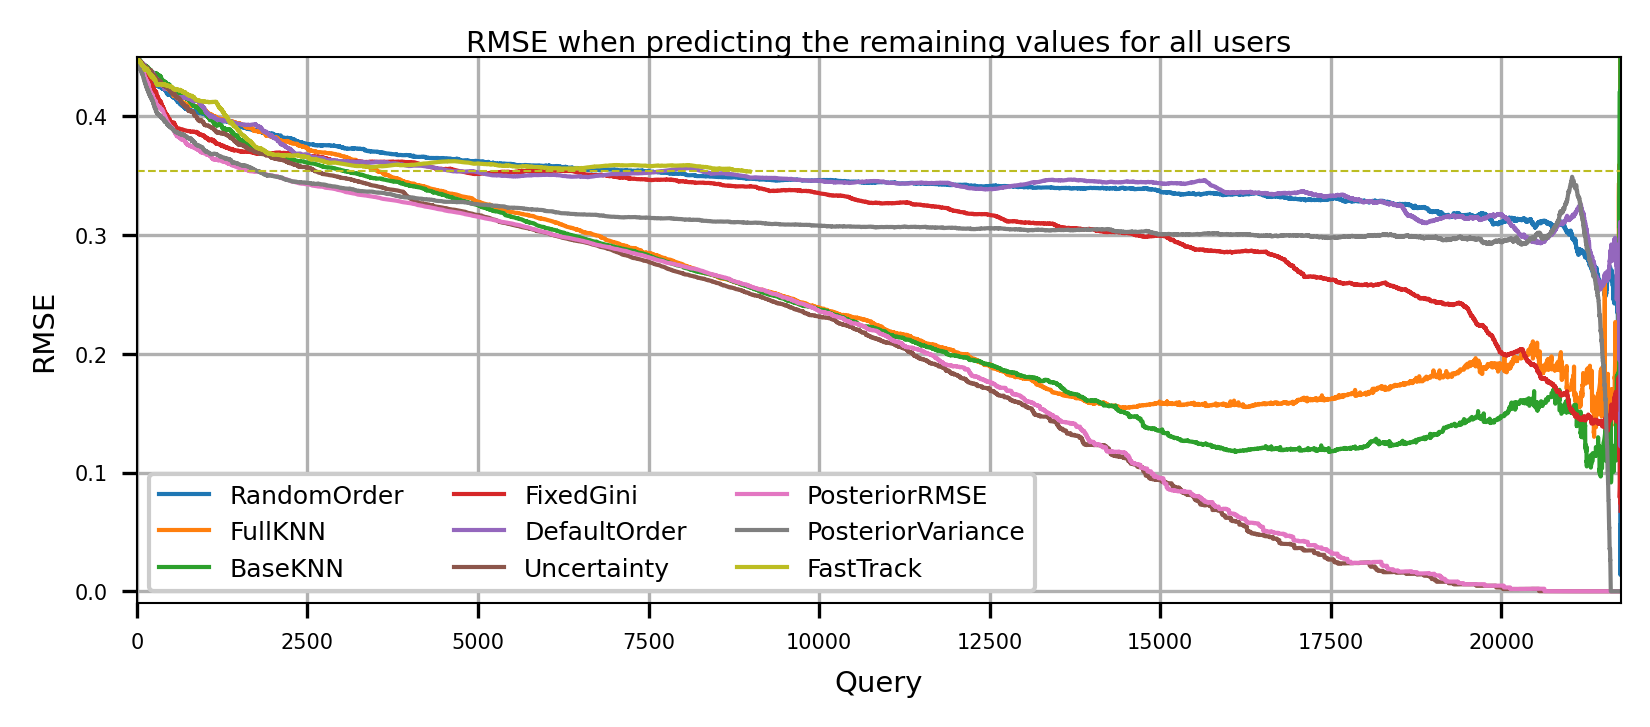

In [61]:
fig, ax = showResults(results, ylim=(-.01, 0.45), savefig=True, metric='RMSE')

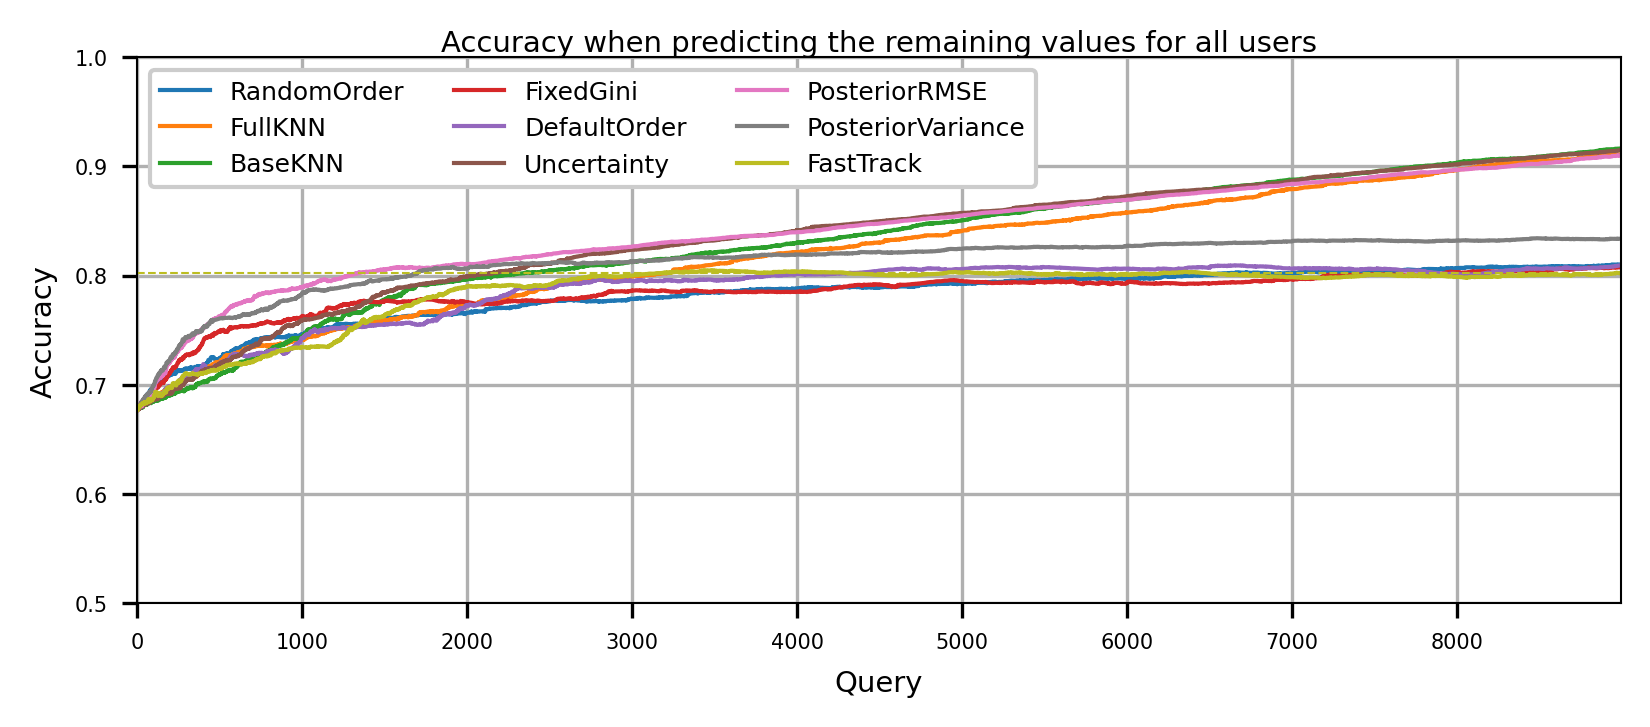

In [62]:
fig, ax = showResults(results, xmax=len(results['FastTrack']))

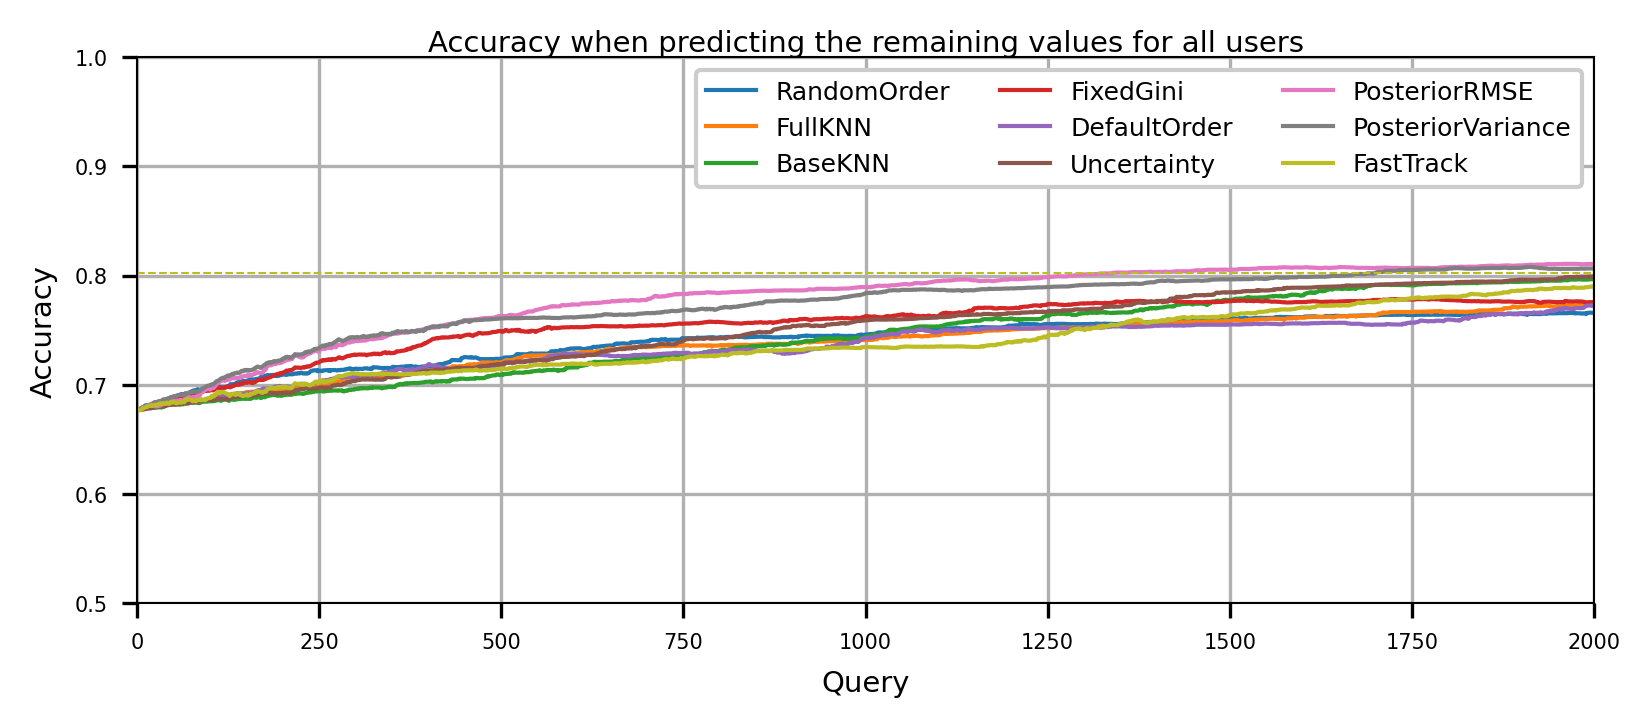

In [63]:
fig, ax = showResults(results, xmax=2000)

### Single Users one by one

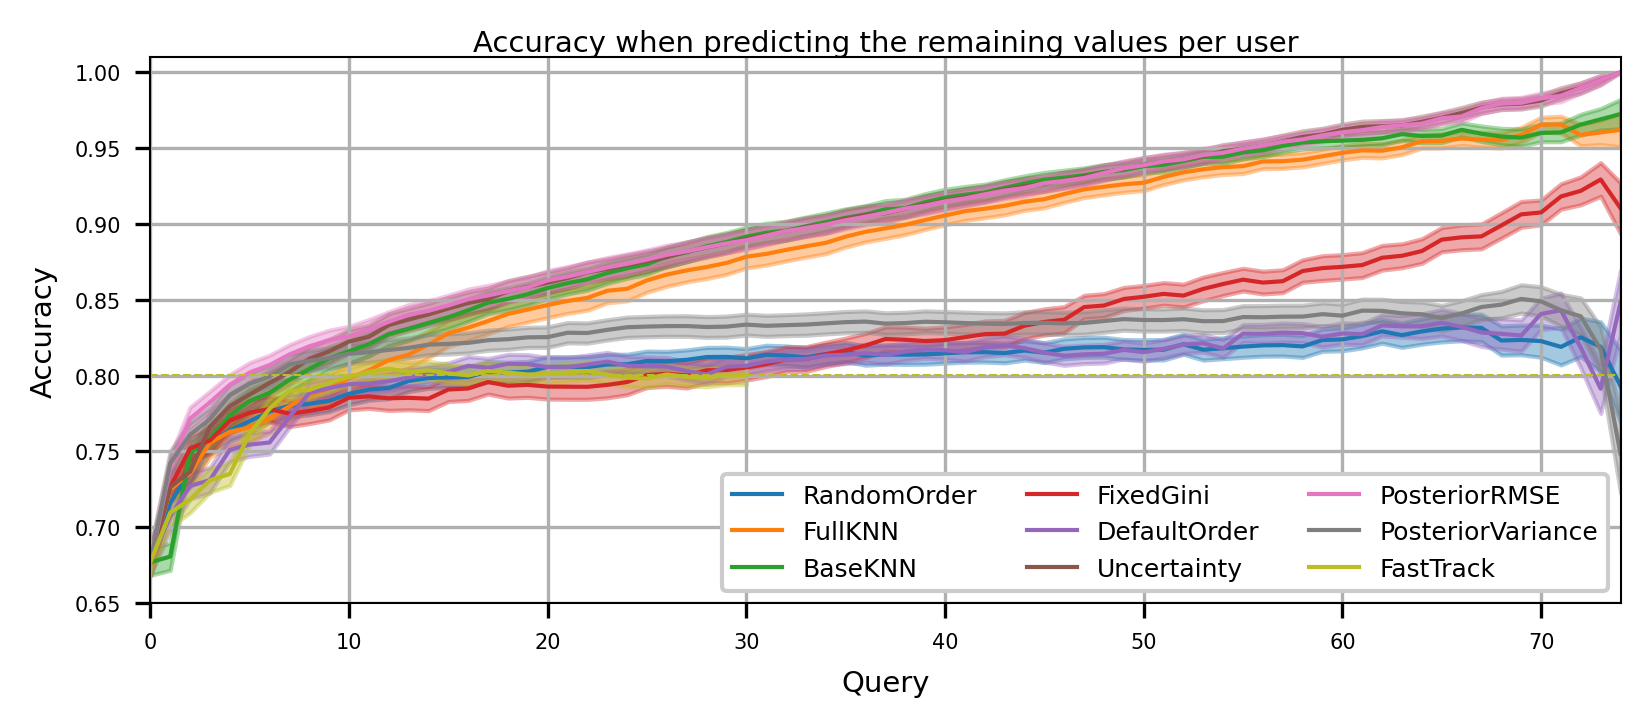

In [64]:
fig, ax = showResults(results, ylim=(0.65,1.01), singleUser=True, savefig=True)

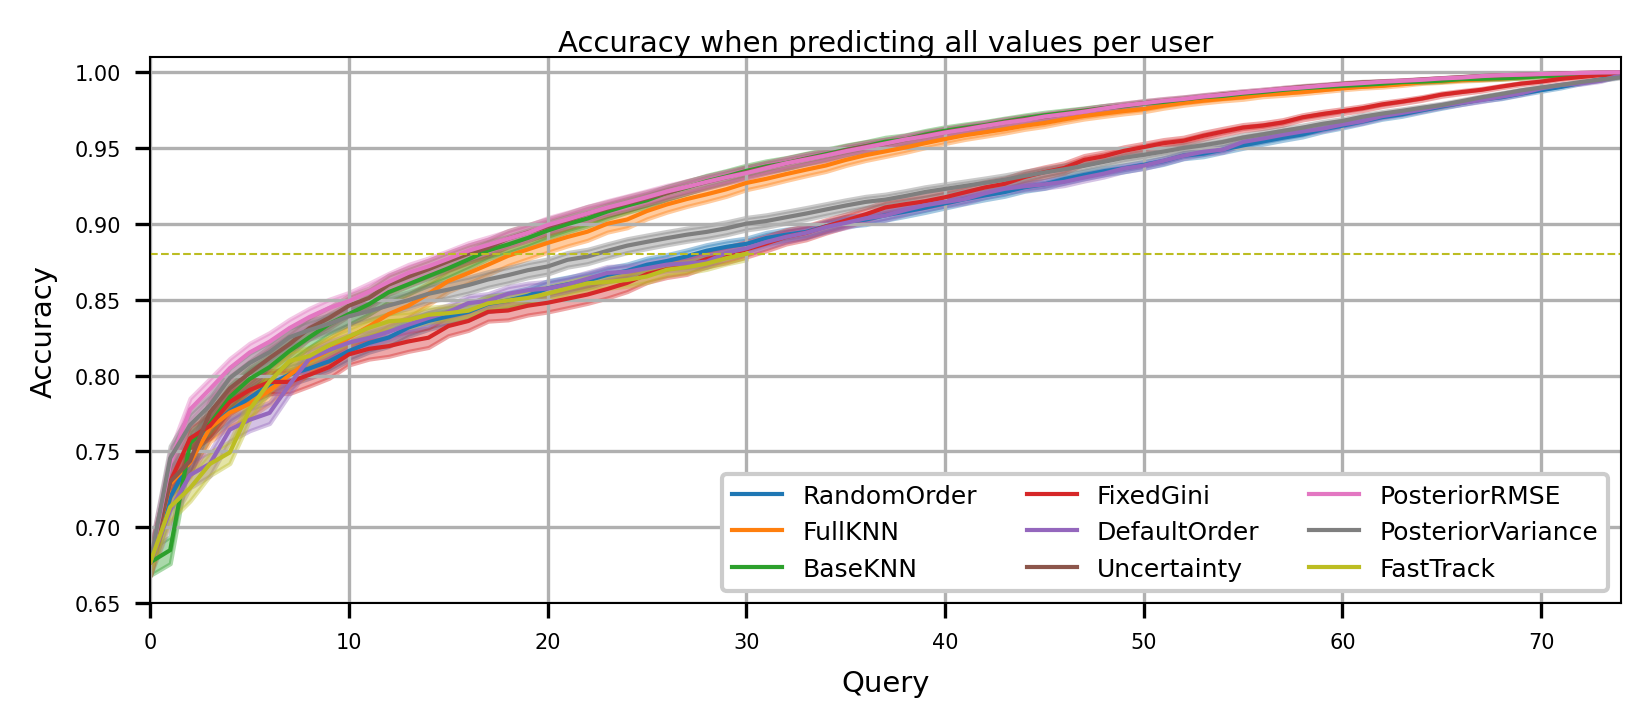

In [65]:
fig, ax = showResults(results, ylim=(0.65,1.01), singleUser=True, includeGiven=True, savefig=True)

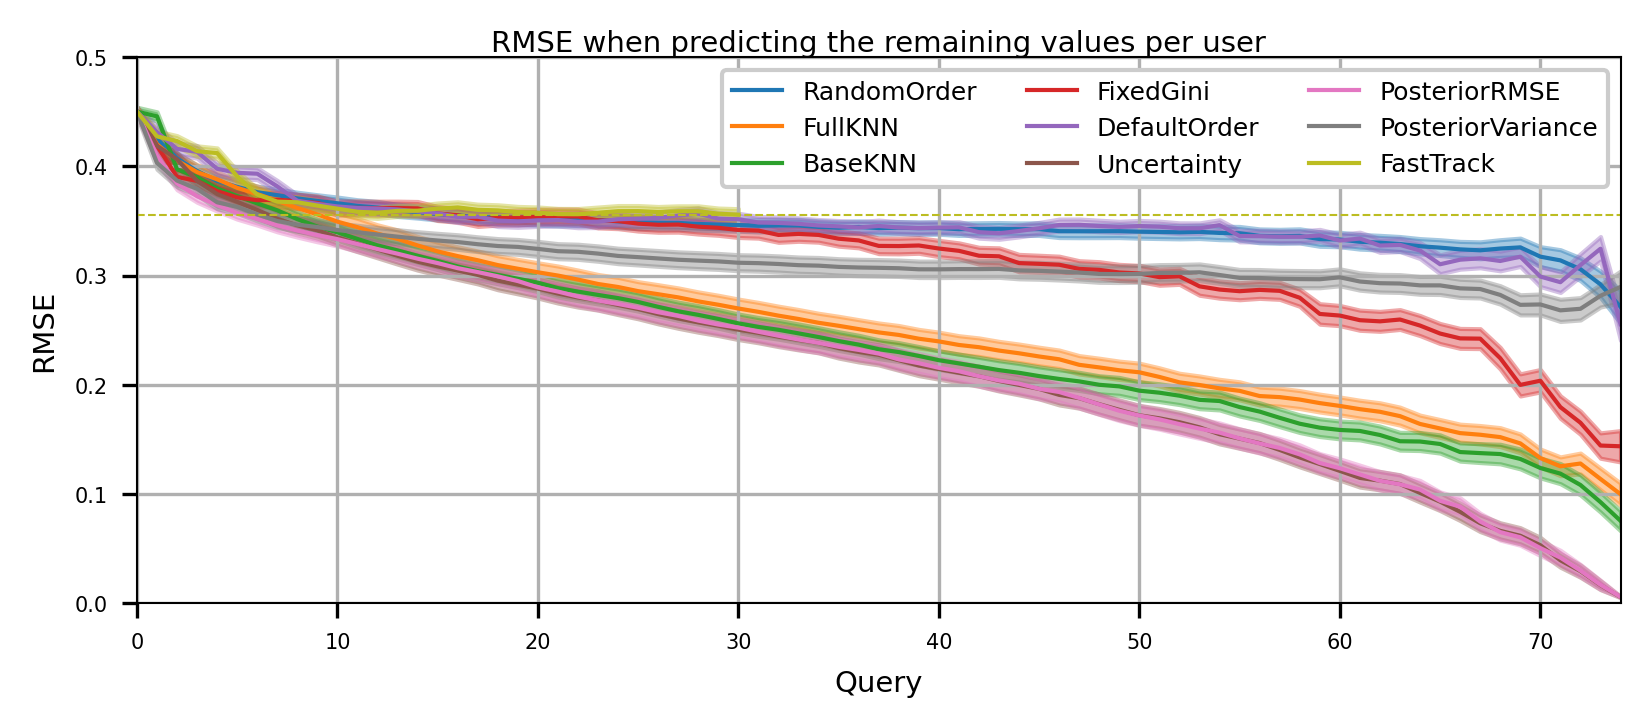

In [66]:
fig, ax = showResults(results, ylim=(0,.5), singleUser=True, metric='RMSE', savefig=True)

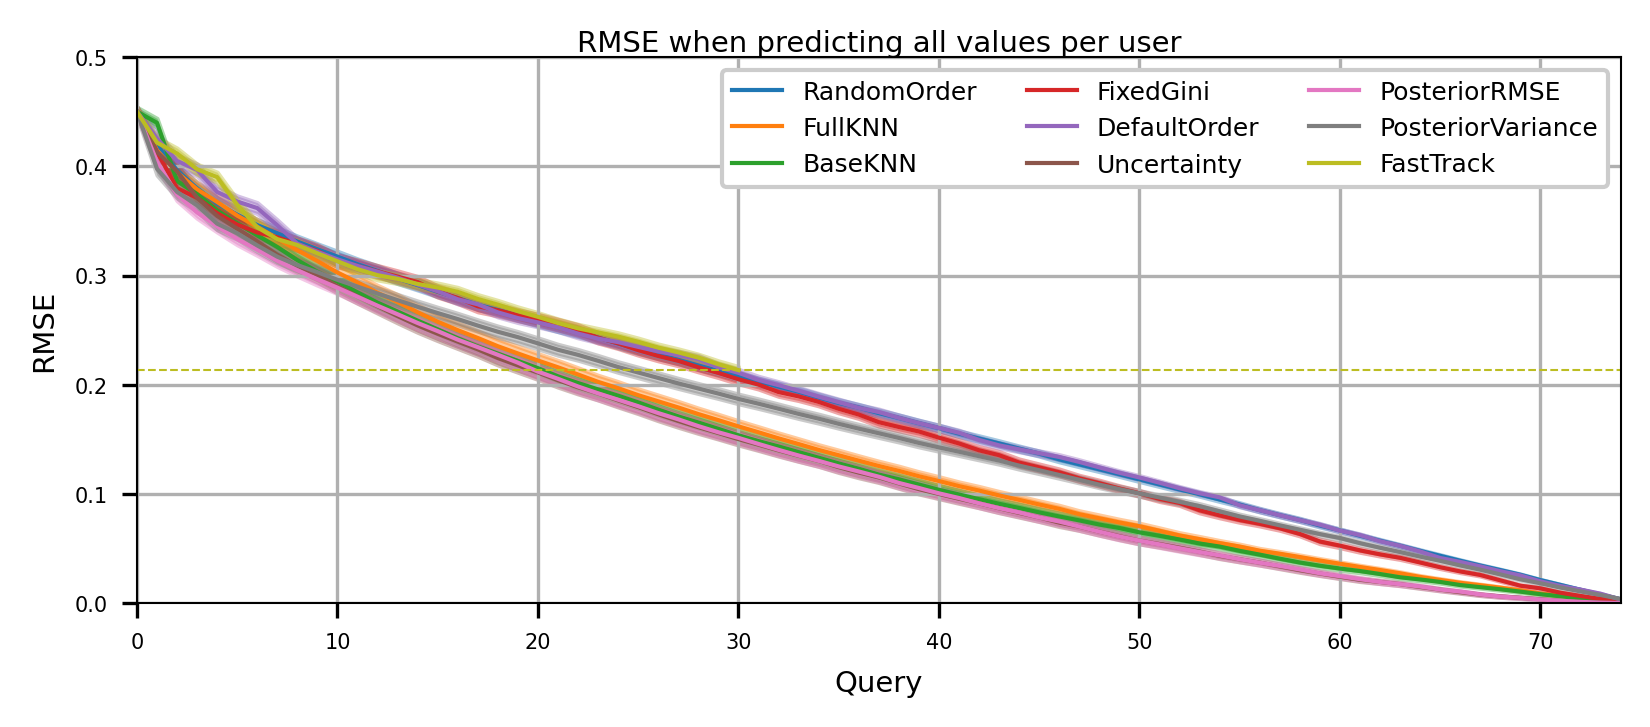

In [67]:
fig, ax = showResults(results, ylim=(0,.5), singleUser=True, metric='RMSE', includeGiven=True, savefig=True)

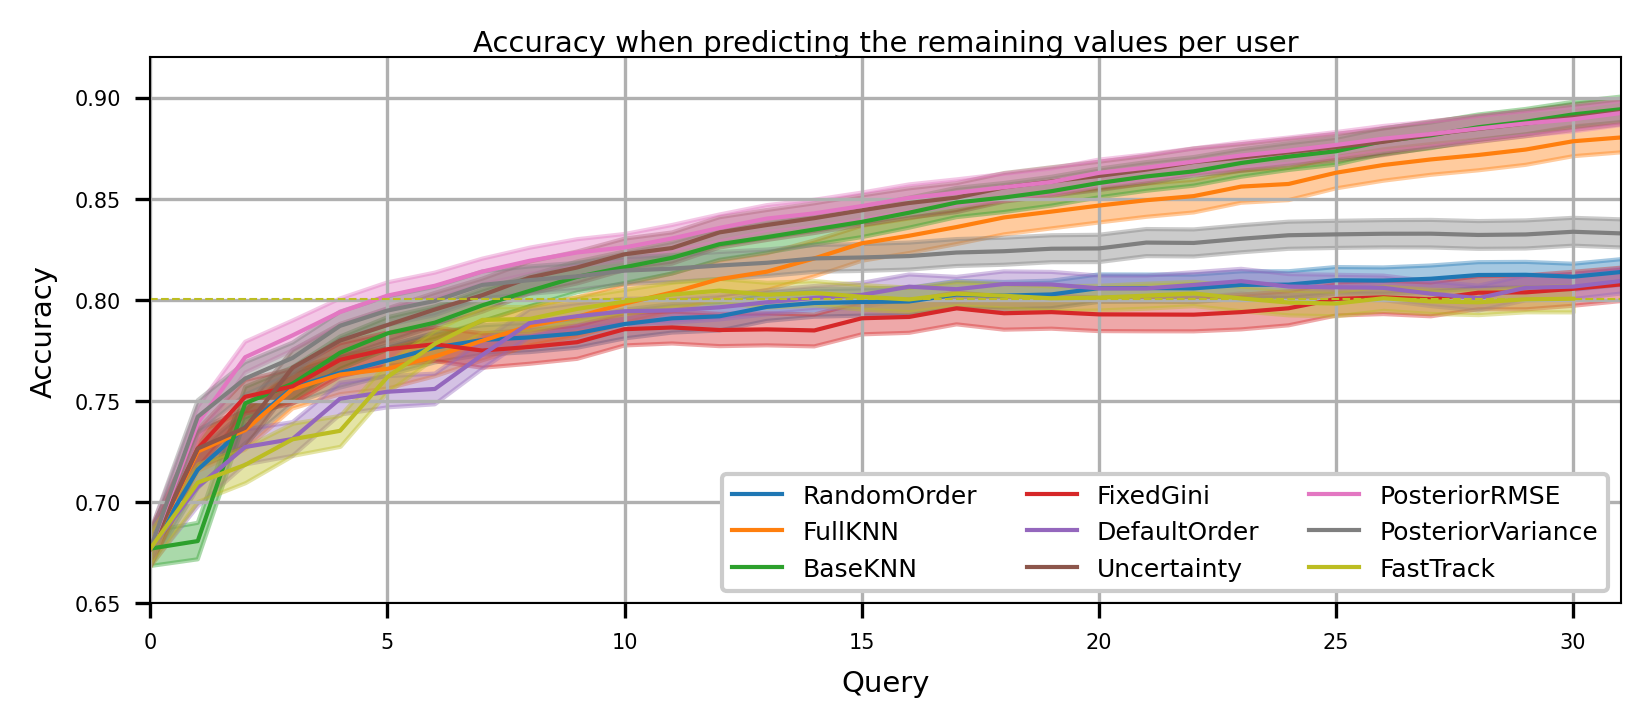

In [68]:
fig, ax = showResults(results, ylim=(0.65,0.92), xmax=31, singleUser=True, metric='Accuracy')

### Priorities

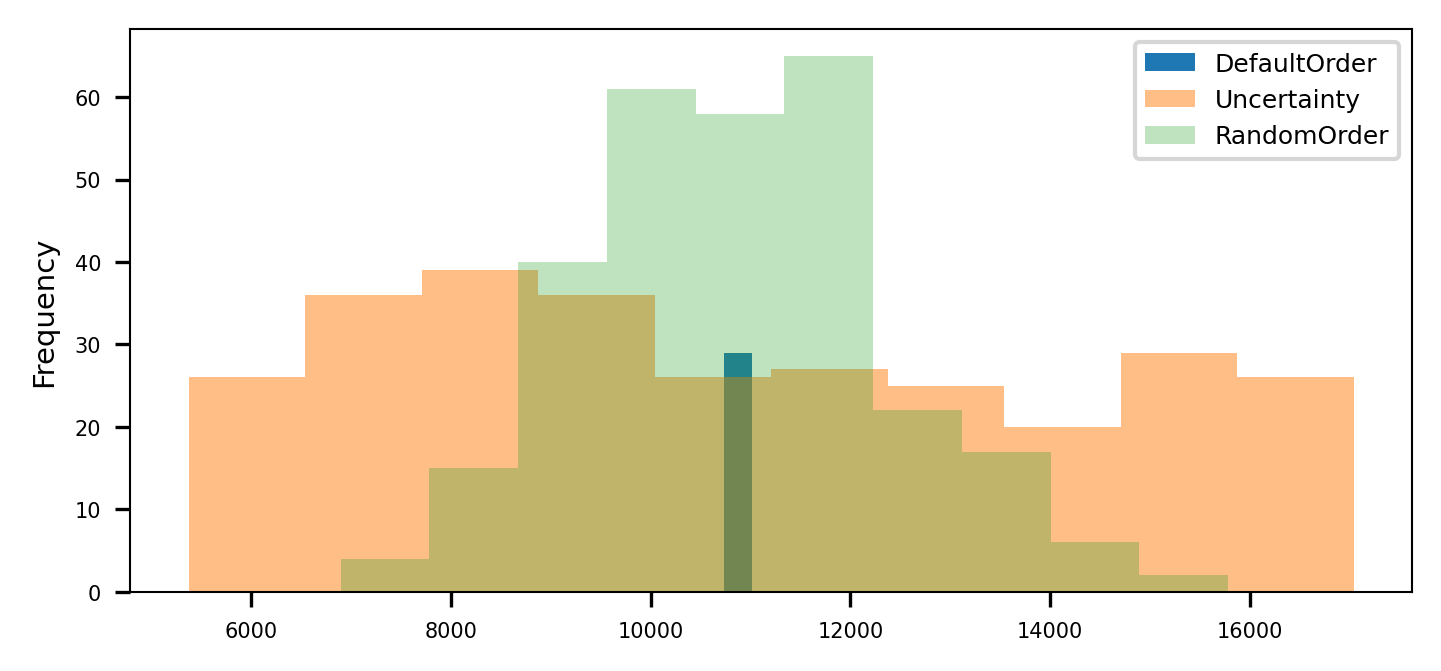

In [31]:
ax = results['DefaultOrder'].reset_index().groupby('User')['index'].mean().plot.hist(label='DefaultOrder')
results['Uncertainty'].reset_index().groupby('User')['index'].mean().plot.hist(ax=ax, alpha=0.5, label='Uncertainty')
results['RandomOrder'].reset_index().groupby('User')['index'].mean().plot.hist(ax=ax, alpha=0.3, label='RandomOrder')
ax.legend()


In [32]:
# from scipy.stats import norm 

# fig, ax = plt.subplots()
# ax2 = ax.twinx()

# stds = []

# for i, method in enumerate(['FastTrack', 'Uncertainty', 'RandomOrder']):
#     alpha = 1 - i/len(methods)
#     K = results[method]['Question'].nunique()
#     xmax = results[method].index.max() - (K-1)/2
#     xmin = results[method].index.min() + (K-1)/2
#     bins = np.linspace(0,1, 20)
#     data = results[method].reset_index().groupby('User')['index'].mean()
#     data = (data - xmin)/(xmax-xmin)
#     hist, _ = np.histogram(results['Uncertainty'].reset_index().groupby('User')['index'].mean()/xmax, bins=bins)
#     ax.bar(bins[:-1], hist)

#     # add a 'best fit' line
#     bins = np.linspace(0,1,1000)
#     mean = data.mean()
#     std = data.std()
#     stds.append(std)
#     best_fit_line = norm.pdf(bins, mean, std)
#     _ = ax2.plot(bins, best_fit_line, label=method)
#     ax2.vlines(mean, 0, 1/std/np.sqrt(2*np.pi), _[0].get_c(), linestyle='--', lw=0.2)

# ymax = 1.1/min(stds)/np.sqrt(2*np.pi)

# # settings
# ax2.set(xlabel = 'priority',
#         ylabel = 'probability density',
#         title  = 'hkl[]',
#         ylim=(0,ymax),
#         xlim=(0,1))

# _ = ax2.legend(ncol=3,facecolor='white', framealpha=1)

## When to stop?

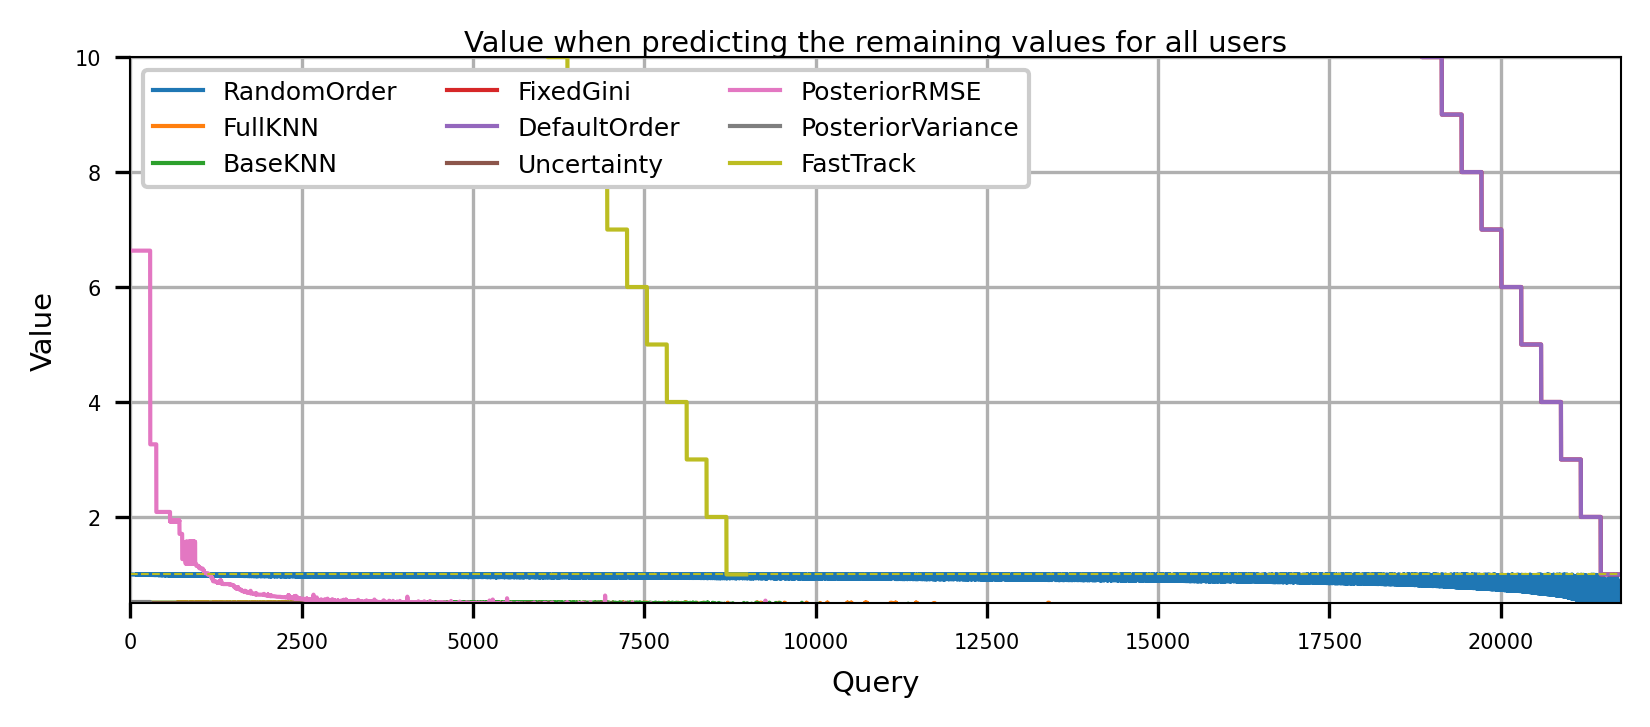

In [33]:
fig, ax = showResults(results, ylim=(0.5,10), savefig=True, metric='Value')